In [1]:
import warnings
warnings.filterwarnings('ignore')
import importlib

import numpy as np
# import wlcstat.wlc_copoly as wlc_copoly
# import wlcstat.wlcstruc as wlcstruc

import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from scipy.interpolate import interp1d

pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

In [2]:
# importlib.reload(GAMcalc.py)

NameError: name 'GAMcalc' is not defined

In [ ]:
# functions edited to:
# -  sfs return with an extra factor of N**something, to match vertex

In [37]:
def calc_monomer_matrix(poly_mat, dens):
    # calculates the AA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    #polymat - each row is a polymer
    #dens is an array where each entry is rel vol frac of correponding polymer
    
    poly_mat = np.array(poly_mat)
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: #single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        M2_AA = np.outer(sig1, sig2)
        return M2_AA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

    #need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
    prods = np.einsum('bi,bo->bio', sigma1*poly_weights, sigma2) # performing row wise cross product (each poly contribution)
    M2_AA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M2_AA


def calc_sf2(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    M2_AA = calc_monomer_matrix(poly_mat, dens)
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m

    grid = np.indices((M, M))
    j1 = grid[0]
    j2 = grid[1]
    
    S2_AA_arr = np.zeros(nk)
    S2_AB_arr = np.zeros(nk)
    S2_BB_arr = np.zeros(nk)
    
    M2_AB = M2_AA[j2, j2] - M2_AA
    M2_BB = 1 - M2_AA[j1, j1] - M2_AA[j2, j2] + M2_AA[j1, j2]
    
    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        k = norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = (j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
        
        C[np.where((index) != 0)] += debye
        
        #j1 > j2, s1 s2 any
        index = (j1 > j2)
        constant = np.exp(-x_m*(j1-j2))
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
        
        #j2 > j1, s1 s2 any
        index = (j2 > j1)
        constant = np.exp(-x_m*(j2-j1))
#         integral is the same

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral   
#         print(C/M**2)
        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
        S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
        S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
    return S2_AA_arr*N**2, S2_AB_arr*N**2, S2_BB_arr*N**2

def calc_sf2_inv(poly_mat, dens, N_m, b, M, k_vec = np.logspace(-2, 2, 50)):
    if norm(k_vec[0]) < 1e-5:
        s2 = np.ones((2,2),dtype='complex')
        N = N_m * M
        return s2/N**2 # s2[0][0]/(N**2), s2[0][1]/(N**2), s2[1][1]/(N**2)
    (S2_AA_arr, S2_AB_arr, S2_BB_arr) = calc_sf2(poly_mat, dens, N_m, b, k_vec)
    det = S2_AA_arr * S2_BB_arr - S2_AB_arr**2
    S2_AA_inv = S2_BB_arr * (1/det)
    S2_AB_inv = -S2_AB_arr * (1/det)
    S2_BB_inv = S2_AA_arr * (1/det)
    
    s2inv = np.zeros((2,2))
    s2inv[0][0] = S2_AA_inv[0]
    s2inv[0][1] = s2inv[1][0] = S2_AB_inv[0]
    s2inv[1][1] = S2_BB_inv[0]
    return s2inv#(S2_AA_inv, S2_AB_inv, S2_BB_inv)

def find_kstar(poly_mat, dens, N_m, b, M, k_vec = np.logspace(-2, 2, 50)):
    (S2_AA_inv, S2_AB_inv, S2_BB_inv) = calc_sf2_inv(poly_mat, dens, N_m, b, M, k_vec)
    G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv) # chi = 0

    # eigvalues,eigvectors = np.linalg.eigh(G2)
    eigvalues_lst = G2
    min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

    k_star = k_vec[np.where(eigvalues_lst==min_eig)]#[0]][0] 
    return k_star

def calc_monomer_matrix_3(poly_mat, dens):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    
    poly_mat = np.array(poly_mat)

    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        alph3 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AAA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AAA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    alph3 =np.zeros((n_p, M))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AAA


def calc_sf3(poly_mat, dens, N_m, b, k_vec, k_vec_2):
    # for a gaussian chain of M monomers, each of length N_m
    
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)
    N = M*N_m

    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr =  np.zeros(nk)
    S3_BAA_arr = np.zeros(nk)
    S3_BBA_arr = np.zeros(nk)
    S3_BBB_arr = np.zeros(nk)
    
    S3_ABA_arr = np.zeros(nk)
    S3_BAB_arr = np.zeros(nk)
    
    S3_AAB_arr = np.zeros(nk)
    S3_ABB_arr = np.zeros(nk)

    
    M3_BAA = M3_AAA[j2, j2, j3] - M3_AAA
    M3_BBA = M3_AAA + M3_BAA[j1, j3, j3] - M3_AAA[j2,j2,j3]
    M3_BBB = 1  - M3_AAA[j1, j1, j1] - M3_BAA[j1, j2, j2] - M3_BAA[j1, j3, j3] + M3_AAA[j2,j2,j3] - M3_AAA
    
#     M3_ABA = M3_AAA[j1,j1,j3] - M3_AAA
#     M3_BAB = M3_AAA[j2,j2,j2] - M3_AAA[j2,j2,j3] - M3_AAA[j1,j2,j2] + M3_AAA
    M3_AAB = M3_AAA[j1, j1, j2] - M3_AAA
    M3_ABB = M3_AAA[j1,j1,j1] - M3_AAA[j1,j1,j2] - M3_AAA[j1,j1,j3] + M3_AAA
    
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2

        # CASE 1; kA = k1 + k2, kB = k_1; S3 > S2 > S1 and S1 > S2 > S3
        case1 = [[k_12, k_1], [j3, j2, j1]]

        # CASE 2; kA = k2, kB = k1 + k2; S2 > S1 > S3 and S3 > S1 > S2
        case2 = [[k_2, k_12], [j2, j1, j3]]
        
        # CASE 3; kA = k2, kB = -k1; S2 > S3 > S1 and S1 > S3 > S2
        case3 = [[k_2, -k_1], [j2, j3, j1]]
        
        case_arr = [case1, case2, case3]#, case1deg, case2deg, case3deg]
        # need to consider degenerate cases. flipping each element in array, then appending to original case array
        case_arr = np.vstack((case_arr, [[np.flipud(el) for el in cse] for cse in case_arr]))
        
#        for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
#        then sum over all indices. Need to keep track of js so that aproiate multiplications with cross corr matrix M3        
        C = np.zeros((M,M,M))

        for cse in case_arr:
            kA, kB = cse[0]
            ordered_js = cse[1]
            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            
            C = calc_case_s3(C, xm_A, xm_B, ordered_js)
    
        S3_AAA_arr[i] += np.sum((1/M**3) * M3_AAA * C)*(N**3)
        S3_BAA_arr[i] += np.sum((1/M**3) * M3_BAA * C)*(N**3)
        S3_BBA_arr[i] += np.sum((1/M**3) * M3_BBA * C)*(N**3)
        S3_BBB_arr[i] += np.sum((1/M**3) * M3_BBB * C)*(N**3)
        
#         S3_ABA_arr[i] += np.sum((1/M**3) * M3_ABA * C)*(N**3)
#         S3_BAB_arr[i] += np.sum((1/M**3) * M3_BAB * C)*(N**3)
        
        S3_AAB_arr[i] += np.sum((1/M**3) * M3_AAB * C)*(N**3)
        S3_ABB_arr[i] += np.sum((1/M**3) * M3_ABB * C)*(N**3)
        
    s3 = np.zeros((2,2,2)) 
    s3[0][0][0] = S3_AAA_arr[0]
    s3[1][0][0] = s3[0][1][0] = S3_BAA_arr[0]
    s3[0][0][1] = S3_AAB_arr[0]
    s3[0][1][1] = s3[1][0][1] = S3_ABB_arr[0]
    s3[1][1][0] = S3_BBA_arr[0]
    s3[1][1][1] = S3_BBB_arr[0]

    return s3# S3_AAA_arr, S3_AAB_arr, S3_ABA_arr, S3_BAA_arr, S3_ABB_arr, S3_BAB_arr,  S3_BBA_arr, S3_BBB_arr

def calc_case_s3(C, xm_A, xm_B, ordered_js):

    jmax, jmid, jmin = ordered_js
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    
    xm_A_eq_0 = False
    if xm_A < 1e-5:
        xm_A_eq_0 = True
        
    xm_B_eq_0 = False
    if xm_B < 1e-5:
        xm_B_eq_0 = True

    #for each sub case, looking at the degenerate case where 1 and 2 are switched
    constant = np.exp(-xm_A*(jmax - jmid)) * np.exp(-xm_B*(jmid - jmin)) 

    # sub case 1; jmax > jmid > jmin, {s1, s2, s3} any 
    index = (jmax > jmid) * (jmid > jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    elif xm_B_eq_0:
        integral = (2*(-1+np.cosh(xm_A)))/ (xm_A**2)
    elif xm_A_eq_0:
        integral = (2*(-1+np.cosh(xm_B)))/ (xm_B**2)
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    # sub case 2; jmax = jmid > jmin, s3 > s2, {s1} any
    index = (jmax == jmid) * (jmid > jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    elif xm_B_eq_0:
        integral = (-1 + xm_A + np.cosh(xm_A) - np.sinh(xm_A))/ (xm_A**2)
    elif xm_A_eq_0:
        integral = (np.exp(-xm_B)*(-1 + np.exp(xm_B))*(1+np.exp(xm_B)*(-1 + xm_B))) / (xm_B**3)   
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral 

    # BONUS sub case 4; jmax > jmid = jmin, s2 > s1, {s3} any 
    index = (jmax > jmid) * (jmid == jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    elif xm_B_eq_0:
        integral = ((-2+xm_A)*(-1+np.cosh(xm_A))+ (xm_A*np.sinh(xm_A)))/ (xm_A**3)
    elif xm_A_eq_0:
        integral = (-1+xm_B+np.cosh(xm_B) - np.sinh(xm_B))/ (xm_B**2)
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral 

    # sub case 3; jmax = jmid = jmin, s3 > s2 > s1
    index = (jmax == jmid) * (jmid == jmin)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    elif xm_B_eq_0:
        integral = (2-2*np.exp(-xm_A) - 2*xm_A + xm_A**2)/ (2*xm_A**3)
    elif xm_A_eq_0:
        integral = (2-2*np.exp(-xm_B) - 2*xm_B + xm_B**2)/ (2*xm_B**3)
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral
    return C


def calc_monomer_matrix_4(poly_mat, dens):
    # calculates the AAAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    poly_mat = np.array(poly_mat)

    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        alph3 =np.zeros(M)
        alph4 =np.zeros(M)

        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
        sig4 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M4_AAAA = np.einsum('i,j,k,l',sig1,sig2,sig3,sig4)
        return M4_AAAA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    alph3 =np.zeros((n_p, M))
    alph4 =np.zeros((n_p, M))
    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    sigma4 = 1*((poly_mat == alph4))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn,bm->bionm', sigma1*poly_weights, sigma2, sigma3, sigma4) # performing row wise cross product (each poly contribution)
    M4_AAAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M4_AAAA

def calc_sf4(poly_mat, dens, N_m, b, k_vec, k_vec_2, k_vec_3):
    M4_AAAA = calc_monomer_matrix_4(poly_mat, dens)
    M = np.shape(M4_AAAA)[0]
    nk = len(k_vec)
    N = M*N_m

    grid = np.indices((M,M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    j4 = grid[3]
    
    S4_AAAA_arr = np.zeros(nk)
    S4_AAAB_arr = np.zeros(nk)
    S4_AABB_arr = np.zeros(nk)
    S4_ABBB_arr = np.zeros(nk)
    S4_BBBB_arr = np.zeros(nk)
    
    S4_ABAB_arr = np.zeros(nk)
    S4_ABBA_arr = np.zeros(nk)
    S4_BBBA_arr = np.zeros(nk)
    S4_BBAB_arr = np.zeros(nk)
    S4_BABB_arr = np.zeros(nk)
    
    M4_BAAA = M4_AAAA[j2, j2, j3, j4] - M4_AAAA
    M4_BBAA = M4_BAAA[j1, j3, j3, j4] - M4_BAAA
    M4_BBBA = M4_BBAA[j1, j2, j4, j4] - M4_BBAA
    M4_BBBB = 1 - M4_AAAA[j1, j1, j1, j1] - M4_AAAA[j2, j2, j2, j2] - M4_AAAA[j3, j3, j3, j3]  + M4_AAAA[j1, j1, j3, j3]\
    + M4_AAAA[j2, j2, j3, j3] + M4_AAAA[j1, j1, j2, j2] - M4_AAAA[j1, j2, j3, j3] - M4_BBBA

    M4_ABAB = M4_AAAA[j1, j1, j3, j3] - M4_AAAA[j1, j1, j3, j4] - M4_AAAA[j1, j1, j2, j3] + M4_AAAA
    M4_ABBA = M4_AAAA[j1,j1,j4,j4] - M4_AAAA[j1, j1, j4, j3] - M4_AAAA[j1, j1, j2, j4] + M4_AAAA[j1, j2, j4, j3]
    M4_BBAB = M4_ABBA[j3, j2, j4, j3] - M4_ABBA[j1, j2, j4, j3]
    M4_BABB = M4_ABBA[j2, j4, j3, j2] - M4_ABBA[j1, j4, j3, j2]
    M4_ABBB = M4_ABBA[j1, j2, j3, j1] - M4_ABBA[j4, j2, j3, j1]
    
    for i, k1 in enumerate(k_vec):
        k2 = k_vec_2[i]
        k3 = k_vec_3[i]
        k12 = k1 + k2
        k13 = k1 + k3
        k23 = k2 + k3
        k123 = k1 + k2 + k3
        
        # CASE 1; kA = k1 + k2 + k3; kB = k_1 + k_2; kC = k_1  S4 > S3 > S2 > S1 (and reverse). All cases on wlcstat
        case1 = [[k123, k12, k1], [j4, j3, j2, j1]]
        case2 = [[k123, k12, k2], [j4, j3, j1, j2]]
        case3 = [[k123, k13, k1], [j4, j2, j3, j1]]
        case4 = [[k123, k23, k2], [j4, j1, j3, j2]]
        case5 = [[k123, k13, k3], [j4, j2, j1, j3]]
        case6 = [[k123, k23, k3], [j4, j1, j2, j3]]
        case7 = [[-k3, k12, k1], [j3, j4, j2, j1]]
        case8 = [[-k3, k12, k2], [j3, j4, j1, j2]]
        case9 = [[-k2, k13, k1], [j2, j4, j3, j1]]
        case10 = [[-k1, k23, k2], [j1, j4, j3, j2]]
        case11 = [[-k2, k13, k3], [j2, j4, j1, j3]]
        case12 = [[-k1, k23, k3], [j1, j4, j2, j3]]
        
        case_arr = [case1, case2, case3, case4, case5, case6, \
                   case7, case8, case9, case10, case11, case12]
        
        # need to consider degenerate cases. flipping each element in array, then appending to original case array
        case_arr = np.vstack((case_arr, [[np.flipud(el) for el in cse] for cse in case_arr]))
        
#        for each case and sub case, add to a matrix C(j1, j2, j3, j4) which contains the contribution to the overall S4
#        then sum over all indices. Need to keep track of js so that aproiate multiplications with cross corr matrix M4 
        C = np.zeros((M,M,M,M))
        for cse in case_arr:
            kA, kB, kC = cse[0]
            ordered_js = cse[1]
            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            xm_C = (1/6) * N_m * b**2 * np.linalg.norm(kC)**2
#             print("xma", xm_A)
#             print("xmb", xm_B)
#             print("xmc", xm_C)
            C = calc_case_s4(C, xm_A, xm_B, xm_C, ordered_js) 
#             print("C", C)
        S4_AAAA_arr[i] += np.sum((1/M**4) * M4_AAAA * C)*(N**4)
        S4_AAAB_arr[i] += np.sum((1/M**4) * M4_BAAA * C)*(N**4)
        S4_AABB_arr[i] += np.sum((1/M**4) * M4_BBAA * C)*(N**4)
        S4_ABBB_arr[i] += np.sum((1/M**4) * M4_BBBA * C)*(N**4)
        S4_BBBB_arr[i] += np.sum((1/M**4) * M4_BBBB * C)*(N**4)
        
        S4_ABAB_arr[i] += np.sum((1/M**4) * M4_ABAB * C)*(N**4)
        S4_ABBA_arr[i] += np.sum((1/M**4) * M4_ABBA * C)*(N**4)
        S4_BBBA_arr[i] += np.sum((1/M**4) * M4_BBBA * C)*(N**4)
        S4_BBAB_arr[i] += np.sum((1/M**4) * M4_BBAB * C)*(N**4)
        S4_BABB_arr[i] += np.sum((1/M**4) * M4_BABB * C)*(N**4)

    s4 = np.zeros((2, 2, 2, 2))
    
    s4[0][0][0][0] = S4_AAAA_arr[0]
    s4[0][0][0][1] = s4[0][0][1][0] = s4[0][1][0][0] = s4[1][0][0][0] = S4_AAAB_arr[0]
    s4[0][0][1][1] = s4[1][1][0][0] = S4_AABB_arr[0]
    s4[1][0][0][1] = s4[0][1][1][0] = S4_ABBA_arr[0]
    s4[1][0][1][0] = s4[0][1][0][1] = S4_ABAB_arr[0]
    s4[1][1][1][0] = S4_BBBA_arr[0]
    s4[1][1][0][1] = S4_BBAB_arr[0]
    s4[1][0][1][1] = S4_BABB_arr[0]
    s4[0][1][1][1] = S4_ABBB_arr[0]
    s4[1][1][1][1] = S4_BBBB_arr[0]
    return s4 # S4_AAAA_arr, S4_AAAB_arr, S4_AABB_arr, S4_ABAB_arr, S4_ABBA_arr, S4_ABBB_arr, S4_BABB_arr, S4_BBAB_arr, S4_BBBA_arr, S4_BBBB_arr 


def calc_case_s4(C, xm_A, xm_B, xm_C, ordered_js):

    jmax, jupp, jlow, jmin = ordered_js
#     ordered_js.reverse()
#     jmax_d, jupp_d, jlow_d, jmin_d = ordered_js
    
    xmA_eq_xmB = False
    xmA_eq_xmC = False
    xmB_eq_xmC = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        xmA_eq_xmB = True
    if xm_A + epsilon > xm_C and xm_A - epsilon < xm_C:
        xmA_eq_xmC = True
    if xm_B + epsilon > xm_C and xm_B - epsilon < xm_C:
        xmB_eq_xmC = True
        
    xm_B_eq_0 = False
    if xm_B < 1e-5:
        xm_B_eq_0 = True
#     print("xmA_eq_xmB")
#     print(xmA_eq_xmB)
#     print("xmA_eq_xmC")
#     print(xmA_eq_xmC)
#     print("xmB_eq_xmC")
#     print(xmB_eq_xmC)

    #for each sub case, looking at the degenerate case where 1 and 2 are switched
    constant = np.exp(-xm_A*(jmax - jupp)- xm_B*(jupp - jlow) - xm_C*(jlow - jmin))
#     constant_deg = np.exp(-xm_A*(jmax_d - jupp_d)- xm_B*(jupp_d - jlow_d) - xm_C*(jlow_d - jmin_d))

    # sub case 1; jmax > jupp > jlow > jmin, {s1234} any
    index = (jmax > jupp) * (jupp > jlow) * (jlow > jmin)
#     index_deg = (jmax_d > jupp_d) * (jupp_d > jlow_d) * (jlow_d > jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = 2*(-1 + np.cosh(xm_A)) / xm_A**2
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = (16 / (xm_A**2 * xm_C**2) )* \
                    np.sinh(xm_A / 2)**2 *np.sinh(xm_C / 2)**2
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (16 / xm_A**4 )* \
                    np.sinh(xm_A / 2)**4
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = (16*np.sinh(xm_A / 2) * np.sinh((xm_A - xm_B)/2) * np.sinh((xm_B - xm_C)/2) * np.sinh(xm_C/2))\
                    / (xm_A * (xm_A - xm_B) * (xm_B - xm_C) * xm_C)
    elif xmA_eq_xmB:
        integral = -(2 / (xm_A*xm_C*(xm_A - xm_C))) * \
                    (-np.sinh(xm_A) + np.sinh(xm_A - xm_C) + np.sinh(xm_C))
    elif xmB_eq_xmC:
        integral = -(2 / (xm_A*xm_B*(xm_A - xm_B))) * \
                    (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))
    elif xmA_eq_xmC:
        integral = (16 / (xm_A**2 * (xm_A - xm_B)**2) )* \
                    np.sinh(xm_A / 2)**2 *np.sinh((xm_A - xm_B) / 2)**2
#     print("subcase 1")
#     print(constant[np.where(index != 0)] \
#                                     * integral)
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral 
    
    # sub case 2; jmax = jupp > jlow > jmin
    index = (jmax == jupp) * (jupp > jlow) * (jlow > jmin)
#     index_deg = (jmax_d == jupp_d) * (jupp_d > jlow_d) * (jlow_d > jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (-1 + np.exp(xm_A)) * (-1 + np.exp(xm_A) - xm_A))\
        / (xm_A**3)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_C))**2 * (1+np.exp(xm_A) *(-1 + xm_A)))\
        /(xm_A**2*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = ((np.exp(-2*xm_A)) * (-1+np.exp(xm_A))**2 * (1+np.exp(xm_A) *(-1 + xm_A)))\
        /(xm_A**2*xm_A**2)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-1+np.exp(xm_C)) * (-np.exp(xm_B)+np.exp(xm_C))\
                    * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B))\
                    / (xm_A*xm_B*xm_C*(xm_A - xm_B) * (xm_C - xm_B))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_C)) * (-np.exp(xm_A)+np.exp(xm_C)) * (-1+np.exp(xm_A) - xm_A))\
        /(xm_A**2*xm_C*(xm_C - xm_A))
    elif xmB_eq_xmC:
        integral = ((-1+np.exp(xm_B))*(xm_A - xm_A*np.exp(-xm_B) + (-1+np.exp(-xm_A))*xm_B))/(xm_B**2*xm_A*(xm_A - xm_B))
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B))*(-1+np.exp(xm_A))*(np.exp(xm_A) - np.exp(xm_B))\
                    *(-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)) / (xm_B*xm_A**2*(xm_A-xm_B)**2)
#     print("subcase 2")
#     print(constant[np.where(index != 0)] \
#                                     * integral)
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral 

    # sub case 3; jmax > jupp = jlow > jmin
    index = (jmax > jupp) * (jupp == jlow) * (jlow > jmin)
#     index_deg = (jmax_d > jupp_d) * (jupp_d == jlow_d) * (jlow_d > jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (-1 + np.cosh(xm_A)) / (xm_A**2)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_A)) * (-1+np.exp(xm_C)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A+xm_C)*(xm_A-xm_C) + np.exp(xm_C)*xm_C))\
        /(xm_A**2*xm_C**2*(xm_A - xm_C))
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (np.exp(-xm_A) * (-1+np.exp(xm_A))**2 * (-1 + np.exp(xm_A) - xm_A))\
        /(xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((1-np.exp(-xm_A))*(-1+np.exp(xm_C))*( ( (1-np.exp(xm_A-xm_B))/(xm_A-xm_B) ) + ( (-1+np.exp(xm_A-xm_C))/(xm_A-xm_C) ) ))/(xm_A*xm_C*(xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_A)) * (-1+np.exp(xm_C)) * (np.exp(xm_A)+np.exp(xm_C)*(-1-xm_A+xm_C)))\
        /(xm_A*xm_C*(xm_A - xm_C)**2)
    elif xmB_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A)) * (-1+np.exp(xm_B)) * (np.exp(xm_B)+np.exp(xm_A)*(-1+xm_A-xm_B)))\
        /(xm_A*xm_B*(xm_A - xm_B)**2)
    elif xmA_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A))**2 * (np.exp(xm_A)+np.exp(xm_B)*(-1-xm_A+xm_B)))/(xm_A**2 * (xm_A - xm_B)**2)
#     print("subcase 3")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral 

    # sub case 4; jmax > jupp > jlow = jmin
    index = (jmax > jupp) * (jupp > jlow) * (jlow == jmin)
#     index_deg = (jmax_d > jupp_d) * (jupp_d > jlow_d) * (jlow_d == jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = ((2+xm_A)*(-1+np.cosh(xm_A)) - xm_A*np.sinh(xm_A))/(xm_A**3)
    
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = (np.exp(-xm_A - xm_C) * (-1+np.exp(xm_A))**2 * (1 + np.exp(xm_C)*(-1 + xm_C)))\
        /(xm_A**2*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (np.exp(-2*xm_A) * (-1+np.exp(xm_A))**2 * (1 + np.exp(xm_A)*(-1 + xm_A)))\
        /(xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-1+np.exp(xm_A)) * (-np.exp(xm_B)+np.exp(xm_A))\
                    * (-np.exp(xm_B)*xm_B + np.exp(xm_C + xm_B)*(xm_B-xm_C) + np.exp(xm_C)*xm_C))\
                    / (xm_A*xm_B*xm_C*(xm_A - xm_B) * (xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A-xm_C)) * (-1+np.exp(xm_A)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A+xm_C)*(xm_A-xm_C)+np.exp(xm_C)*xm_C)) / (xm_A**2*xm_C*(xm_A - xm_C))
    elif xmB_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A)) * (-np.exp(xm_A)+np.exp(xm_B)) * (-1+np.exp(xm_B) - xm_B))\
        /(xm_A*xm_B**2*(xm_B - xm_A))
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B))*(-1+np.exp(xm_A))*(np.exp(xm_A) - np.exp(xm_B))\
                    *(-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)) / (xm_B*xm_A**2*(xm_A-xm_B)**2)

#     print("subcase 4")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral 
    
    # sub case 5; jmax == jupp == jlow > jmin
    index = (jmax == jupp) * (jupp == jlow) * (jlow > jmin)
#     index_deg = (jmax_d == jupp_d) * (jupp_d == jlow_d) * (jlow_d > jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (-1 + np.exp(xm_A)) * (-2 + 2*np.exp(xm_A) - 2*xm_A - xm_A**2))\
        / (2*xm_A**4)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = ((-1+np.ezp(xm_C))*( -xm_C + (   (xm_A*(-1+np.exp(-xm_C) + xm_C))  / (xm_C)  ) +  ( (xm_C-np.exp(-xm_A)*xm_C)  / (xm_A)  )     )) / (xm_A*(xm_A-xm_C)*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (4-4*np.cosh(xm_A) + 2*xm_A*np.sinh(xm_A)) / (xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((-1+np.exp(xm_C)) * (  ( (np.exp(-xm_B))/((xm_A-xm_B)*xm_B)   )  +  ( (xm_B - xm_C)/(xm_A*xm_B*xm_C)  )  +   (   (np.exp(-xm_C))/(xm_C*(xm_C-xm_A))    )  +    (    (np.exp(-xm_A)*(-xm_B+xm_C)) / ( xm_A*(xm_A-xm_B)*(xm_A-xm_C))  )   ))/((xm_B-xm_C)*xm_C)
    elif xmA_eq_xmB:
        integral = ((-1+np.exp(xm_C))* (  (-np.exp(-xm_C) * xm_A**2)     +    ((xm_A-xm_C)**2)    +     (np.exp(-xm_A)*xm_C*(xm_A**2 - xm_A*(-2+xm_C)-xm_C)) ))/(xm_A**2*xm_C**2*(xm_A-xm_C)**2)
    elif xmB_eq_xmC:
        integral = -((-1+np.exp(xm_B))* (  (np.exp(-xm_A) * xm_B**2)     +    -((xm_A-xm_B)**2)    +     (np.exp(-xm_B)*xm_A*(xm_A*(1+xm_B) - xm_B*(2+xm_B))) ))/(xm_B**3*xm_A*(xm_A-xm_B)**2)
    elif xmA_eq_xmC:
        integral = ((-1+np.exp(xm_A))* (  (-np.exp(-xm_B) * xm_A**2)     +    ((xm_A-xm_B)**2)    +     (np.exp(-xm_A)*xm_B*(xm_A**2 - xm_A*(-2+xm_B)-xm_B)) ))/(xm_A**3*xm_B*(xm_A-xm_B)**2)

#     print("subcase 5")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral 
    
    # sub case 6; jmax > jupp == jlow = jmin
    index = (jmax > jupp) * (jupp == jlow) * (jlow == jmin)
#     index_deg = (jmax_d > jupp_d) * (jupp_d == jlow_d) * (jlow_d == jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = ((-1 + np.exp(-xm_A)) * (2 - 2*np.exp(xm_A) + 2*xm_A + xm_A**2))\
        / (2*xm_A**4)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = (np.exp(-xm_A - xm_C)) * (-1 + np.exp(xm_A)) * ( (np.exp(xm_A)*xm_A**2)  +   (np.exp(xm_A+xm_C)*(xm_A-xm_C)*(xm_A*(-1+xm_C) -xm_C) )   -    (np.exp(xm_C)*xm_C**2) ) / (xm_A**3*(xm_A-xm_C)*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (4-4*np.cosh(xm_A) + 2*xm_A*np.sinh(xm_A)) / (xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ( (np.exp(-xm_A - xm_B - xm_C)) * (-1+np.exp(xm_A)) * \
                   (          (-np.exp(xm_A+xm_B)*xm_A*(xm_A-xm_B)*xm_B)      +         (np.exp(xm_A+xm_C)*xm_A*(xm_A-xm_C)*xm_C)     +       (np.exp(xm_B+xm_C)*(xm_B-xm_C)*(np.exp(xm_A)*(xm_A-xm_B)*(xm_A-xm_C) -xm_B*xm_C) )     ))\
                    / (xm_A**2 * (xm_A - xm_B) * xm_B * (xm_A-xm_C) * (xm_B - xm_C) * xm_C)
    elif xmA_eq_xmB:
        integral = ( (np.exp(-xm_A - xm_C)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_A)*xm_A**2) +   (np.exp(xm_A+xm_C)*(xm_A-xm_C)**2)    +    -(np.exp(xm_C)*xm_C*(-xm_A**2+xm_A*(-2+xm_C)+xm_C)) ))/ (xm_A**3*(xm_A-xm_C)**2*xm_C)
    elif xmB_eq_xmC:
        integral = ( (np.exp(-xm_A - xm_B)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_B)*xm_B**2) +   (np.exp(xm_A+xm_B)*(xm_A-xm_B)**2)    +    -(np.exp(xm_A)*xm_A*(xm_A*(1+xm_B)-xm_B*(2+xm_B))) ))/ (xm_A**2*(xm_A-xm_B)**2*xm_B**2)
    elif xmA_eq_xmC:
        integral = ( (np.exp(-xm_A - xm_B)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_A)*xm_A**2) +   (np.exp(xm_A+xm_B)*(xm_A-xm_B)**2)    +    -(np.exp(xm_B)*xm_B*(-xm_A**2+xm_A*(-2+xm_B)+xm_B)) ))/ (xm_A**3*(xm_A-xm_B)**2*xm_B)
#     print("subcase 6")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral  
    
    # sub case 7; jmax == jupp == jlow = jmin
    index = (jmax == jupp) * (jupp == jlow) * (jlow == jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (6 + 2*(np.exp(xm_A)*(-3+xm_A)) + 4*xm_A + xm_A**2) ) / (2*xm_A**4)
    
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = (  (2*(-1 + np.exp(-xm_A))*xm_C**3) + (2*xm_A*xm_C**3)  + (-xm_A**2*xm_C**3) + (xm_A**3*(2-2*np.exp(-xm_C)-2*xm_C+xm_C**2)) ) / (2*xm_A**3*(xm_A-xm_C)*xm_C**3)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (np.exp(-xm_A) / (2*xm_A**4)) * ( (-2*(3+xm_A)) + (np.exp(xm_A) * (6-4*xm_A + xm_A**2)))

    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ( (np.exp(-xm_A)) / (xm_A**2 * (xm_A-xm_B) * (xm_A - xm_C)) )      +      ( (np.exp(-xm_B)) / (xm_B**2 * (xm_B-xm_A) * (xm_B - xm_C)) )     +      ( (np.exp(-xm_C)) / (xm_C**2 * (xm_C-xm_A) * (xm_C - xm_B)) )      +        -(  (xm_B*xm_C + xm_A*(xm_B+xm_C-xm_B*xm_C))   /    (xm_A**2*xm_B**2*xm_C**2)  )
    elif xmA_eq_xmB:
        integral = (  (-xm_A**3) + (np.exp(-xm_C)*xm_A**3) + (xm_A*(xm_A-xm_C)**2*xm_C) + ((3*xm_A-2*xm_C)*xm_C**2) + ( np.exp(-xm_A)*xm_C**2 *(2*xm_C + xm_A*(-3-xm_A+xm_C))) ) / (xm_A**3 * xm_C**2 * (xm_A - xm_C)**2)
    elif xmB_eq_xmC:
        integral = ( ((xm_A - xm_B)**2 * (xm_A*(-2 + xm_B) - xm_B))     +     (np.exp(-xm_A) * xm_B**3)     +    (np.exp(-xm_B)*xm_A**2 * (xm_A*(2+xm_B) - xm_B*(3 + xm_B))  )      ) / (xm_A**2 * (xm_A - xm_B)**2 * xm_B**3)
    elif xmA_eq_xmC:
        integral =  (  (-xm_A**3) + (np.exp(-xm_B)*xm_A**3) + (xm_A*(xm_A-xm_B)**2*xm_B) + ((3*xm_A-2*xm_B)*xm_B**2) + ( np.exp(-xm_A)*xm_B**2 *(2*xm_B + xm_A*(-3-xm_A+xm_B))) ) / (xm_A**3 * xm_B**2 * (xm_A - xm_B)**2)
#     print("subcase 7")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral #* 2
    # sub case 8; jmax == jupp > jlow = jmin
    index = (jmax == jupp) * (jupp > jlow) * (jlow == jmin)
#     index_deg = (jmax_d == jupp_d) * (jupp_d > jlow_d) * (jlow_d == jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (1 + -np.exp(xm_A) +xm_A)**2)\
        / (xm_A**4)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = ((np.exp(-xm_A - xm_C)) * (1+np.exp(xm_A) *(-1 + xm_A))*(1+np.exp(xm_C)*(-1+xm_C)))\
        /(xm_A**2*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = ( np.exp(-2*xm_A) * (1+np.exp(xm_A)*(-1 + xm_A))**2)\
        /(xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B) *(-np.exp(xm_B)*xm_B + np.exp(xm_B + xm_C)*(xm_B-xm_C) + np.exp(xm_C)*xm_C) )\
                    / (xm_A*xm_B**2*xm_C*(xm_A - xm_B) * (xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ( (np.exp(-xm_A - xm_C)) * (-1 + np.exp(xm_A)-xm_A) * ( (-np.exp(xm_A)*xm_A) +   (np.exp(xm_A+xm_C)*(xm_A-xm_C))    +  (np.exp(xm_C)*xm_C) ))/ (xm_A**3*(xm_A-xm_C)*xm_C)
    elif xmB_eq_xmC:
        integral = ( (-1+np.exp(xm_B) - xm_B) * (xm_A-np.exp(-xm_B)*xm_A + (-1+np.exp(-xm_A))*xm_B) )/ (xm_A*(xm_A-xm_B)*xm_B**3)
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A+xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)**2) / (xm_A**2*xm_B**2*(xm_A-xm_B)**2)
#     print("subcase 8")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral
    return C



def spinodal_gaus(poly_mat, dens, N_m, b, M):
    chi = 0
#     K0 = 1/np.sqrt(r2(N))
    
    KS = optimize.fmin(lambda K: np.real(gamma2_E(poly_mat, dens, N_m, b, M, K, chi)), 0.01,\
                      disp=False)
    
    return KS

def gamma2_E(poly_mat, dens, N_m, b, M, k, chi):
# like an ensemble-averaged G2, using gaussian chain 
#     (S2_AA_inv, S2_AB_inv, S2_BB_inv) = calc_sf2_inv(poly_mat, dens, N_m, b, M, [k])
#     s2_inv_mat = np.zeros((2, 2))
#     s2_inv_mat[0][0] = S2_AA_inv
#     s2_inv_mat[0][1] = s2_inv_mat[1][0] = S2_AB_inv
#     s2_inv_mat[1][1] = S2_BB_inv
    
    s2_inv = calc_sf2_inv(poly_mat, dens, N_m, b, M, [k])

    D = [1,-1]    # sign indicator
    G = 0
    for I0, I1 in product([0,1], repeat=2):
        G += s2_inv[I0, I1]*D[I0]*D[I1]
        
    return -2*chi + N*G

def gamma3_E(poly_mat, dens, N_m, b, M, Ks):
    K1, K2, K3 = Ks
    if norm(K1+K2+K3) >= 1e-10:
        raise('Qs must add up to zero')
        
    if not (abs(norm(K1)-norm(K2)) < 1e-5 \
        and abs(norm(K2)-norm(K3)) < 1e-5):
        raise('Qs must have same length')
        
#     (sf3_AAA, sf3_AAB, sf3_ABA, sf3_BAA, sf3_ABB, sf3_BAB, sf3_ABB, sf3_BBB) = calc_sf3(poly_mat, dens, N_m, b, [K1], [K2])
    
#     (S2_AA_inv, S2_AB_inv, S2_BB_inv) = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K1])
    
#     s2inv = np.zeros((2, 2))
#     s2inv[0][0] = S2_AA_inv
#     s2inv[0][1] = s2inv[1][0] = S2_AB_inv
#     s2inv[1][1] = S2_BB_inv
    
    s2inv = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K1])
    
    s3 = calc_sf3(poly_mat, dens, N_m, b, [K1], [K2])
#     s3[0][0][0] = sf3_AAA
#     s3[1][0][0] = s3[0][1][0] = s3[0][0][1] = sf3_AAB
#     s3[1][1][0] = s3[1][0][1] = s3[0][1][1] = sf3_ABB
#     s3[1][1][1] = sf3_BBB

#     s3[0][0][0] = sf3_AAA
#     s3[1][0][0] = s3[0][1][0] = sf3_BAA
#     s3[0][0][1] = sf3_AAB
#     s3[0][1][1] = s3[1][0][1] = sf3_ABB
#     s3[1][1][0] = sf3_BBA 
#     s3[1][1][1] = sf3_BBB
    
#     print("GAUS S3, S2inv")
#     print(s3)
#     print(s2inv)
    val = 0
    for I0, I1, I2 in product([0,1], repeat=3):
        val -= s3[I0][I1][I2]* (s2inv[I0][0] - s2inv[I0][1])*\
                               (s2inv[I1][0] - s2inv[I1][1])*\
                               (s2inv[I2][0] - s2inv[I2][1])
    
    return val*(N**2) 

def gamma4_E(poly_mat, dens, N_m, b, M, Ks):
    K1, K2, K3, K4 = Ks
    if not (abs(norm(K1)-norm(K2)) < 1e-5
            and abs(norm(K2)-norm(K3)) < 1e-5
            and abs(norm(K3)-norm(K4)) < 1e-5):
        print(K1, K2, K3, K4)
        raise('Qs must have same length')
    
    N = M * N_m
        
    K = norm(K1)
    K12 = norm(K1+K2)
    K13 = norm(K1+K3)
    K14 = norm(K1+K4)

#     print("k2")
#     print(K2)
#     print("k4")
#     print(K4)


#     s4_AAAA, s4_AAAB, s4_AABB, s4_ABAB, s4_ABBA,\
#     s4_ABBB, s4_BABB, s4_BBAB, s4_BBBA, s4_BBBB = calc_sf4(poly_mat, dens, N_m, b, [K1], [K2], [K3]) 
    
#     (sf31_AAA, sf31_AAB, sf31_ABA, sf31_BAA, sf31_ABB, sf31_BAB, sf31_BBA, sf31_BBB) = calc_sf3(poly_mat, dens, N_m, b, [K1], [K2])

#     (sf32_AAA, sf32_AAB, sf32_ABA, sf32_BAA, sf32_ABB, sf32_BAB, sf32_BBA, sf32_BBB) = calc_sf3(poly_mat, dens, N_m, b, [K1], [K3])

#     (sf33_AAA, sf33_AAB, sf33_ABA, sf33_BAA, sf33_ABB, sf33_BAB, sf33_BBA, sf33_BBB) = calc_sf3(poly_mat, dens, N_m, b, [K1], [K4])
# sf3_AAA, sf3_AAB, sf3_ABA, sf3_BAA, sf3_ABB, sf3_BAB, sf3_BBA, sf3_BBB
#     (S2_AA_inv, S2_AB_inv, S2_BB_inv) = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K])

#     (S2_AA_inv_1, S2_AB_inv_1, S2_BB_inv_1) = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K12])

#     (S2_AA_inv_2, S2_AB_inv_2, S2_BB_inv_2) = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K13])

#     (S2_AA_inv_3, S2_AB_inv_3, S2_BB_inv_3) = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K14])

    s4 = calc_sf4(poly_mat, dens, N_m, b, [K1], [K2], [K3]) 
    
#     s4[0][0][0][0] = s4_AAAA
#     s4[0][0][0][1] = s4[0][0][1][0] = s4[0][1][0][0] = s4[1][0][0][0] = s4_AAAB
#     s4[0][0][1][1] = s4[1][1][0][0] = s4_AABB
#     s4[1][0][0][1] = s4[0][1][1][0] = s4_ABBA
#     s4[1][0][1][0] = s4[0][1][0][1] = s4_ABAB
#     s4[1][1][1][0] = s4_BBBA
#     s4[1][1][0][1] = s4_BBAB
#     s4[1][0][1][1] = s4_BABB
#     s4[0][1][1][1] = s4_ABBB
#     s4[1][1][1][1] = s4_BBBB

    
    s31 = calc_sf3(poly_mat, dens, N_m, b, [K1], [K2])
#     s31[0][0][0] = sf31_AAA
#     s31[1][0][0] = s31[0][1][0] = sf31_BAA
#     s31[0][0][1] = sf31_AAB
#     s31[0][1][1] = s31[1][0][1] = sf31_ABB
#     s31[1][1][0] = sf31_BBA 
#     s31[1][1][1] = sf31_BBB
    
    
    s32 = calc_sf3(poly_mat, dens, N_m, b, [K1], [K3])
#     s32[0][0][0] = sf32_AAA
#     s32[1][0][0] = s32[0][1][0] = sf32_BAA
#     s32[0][0][1] = sf32_AAB
#     s32[0][1][1] = s32[1][0][1] = sf32_ABB
#     s32[1][1][0] = sf32_BBA 
#     s32[1][1][1] = sf32_BBB
    

    s33 = calc_sf3(poly_mat, dens, N_m, b, [K1], [K4])
#     s33[0][0][0] = sf33_AAA
#     s33[1][0][0] = s33[0][1][0] = sf33_BAA
#     s33[0][0][1] = sf33_AAB
#     s33[0][1][1] = s33[1][0][1] = sf33_ABB
#     s33[1][1][0] = sf33_BBA 
#     s33[1][1][1] = sf33_BBB
    
    
#     # copying vertex!
#     M2_AA = calc_monomer_matrix(poly_mat, dens)
#     FA = np.sum(np.diag(M2_AA)) / M  # ensemble-average f_A
#     FB = 1 - FA 
#     N = M * N_m
#     print("K1")
#     print(K1)
#     print("K2")
#     print(K2)
#     print("K3")
#     print(K3)
#     if norm(-K1 - K2) < 1e-5:
#         #calc s2
#         print("0q S31")
#         s2_AA, s2_AB, s2_BB = calc_sf2(poly_mat, dens, N_m, b, [K1])
#         s31[0][0][0] = s2_AA*FA*N
#         s31[0][0][1] = s2_AA*FB*N
#         s31[0][1][0] = s2_AB*FA*N
#         s31[0][1][1] = s2_AB*FB*N
#         s31[1][0][0] = s2_AB*FA*N
#         s31[1][0][1] = s2_AB*FB*N
#         s31[1][1][0] = s2_BB*FA*N
#         s31[1][1][1] = s2_BB*FB*N

#     if norm(-K1 - K3) < 1e-5:
#         #calc s2
#         print("0q S32")
#         s2_AA, s2_AB, s2_BB = calc_sf2(poly_mat, dens, N_m, b, [K1])
#         s32[0][0][0] = s2_AA*FA*N
#         s32[0][0][1] = s2_AA*FB*N
#         s32[0][1][0] = s2_AB*FA*N
#         s32[0][1][1] = s2_AB*FB*N
#         s32[1][0][0] = s2_AB*FA*N
#         s32[1][0][1] = s2_AB*FB*N
#         s32[1][1][0] = s2_BB*FA*N
#         s32[1][1][1] = s2_BB*FB*N
    
#     if norm(-K1 - K4) < 1e-5:
#         #calc s2
#         print("0q S33")
#         s2_AA, s2_AB, s2_BB = calc_sf2(poly_mat, dens, N_m, b, [K1])
#         s33[0][0][0] = s2_AA*FA*N
#         s33[0][0][1] = s2_AA*FB*N
#         s33[0][1][0] = s2_AB*FA*N
#         s33[0][1][1] = s2_AB*FB*N
#         s33[1][0][0] = s2_AB*FA*N
#         s33[1][0][1] = s2_AB*FB*N
#         s33[1][1][0] = s2_BB*FA*N
#         s33[1][1][1] = s2_BB*FB*N
        
    
    s2inv = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K])
#     s2inv[0][0] = S2_AA_inv
#     s2inv[0][1] = s2inv[1][0] = S2_AB_inv
#     s2inv[1][1] = S2_BB_inv
    
    s21inv = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K12])
#     s21inv[0][0] = S2_AA_inv_1
#     s21inv[0][1] = s21inv[1][0] = S2_AB_inv_1
#     s21inv[1][1] = S2_BB_inv_1

    s22inv = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K13])
#     s22inv[0][0] = S2_AA_inv_2
#     s22inv[0][1] = s22inv[1][0] = S2_AB_inv_2
#     s22inv[1][1] = S2_BB_inv_2
    
    s23inv = calc_sf2_inv(poly_mat, dens, N_m, b, M, [K14])
#     s23inv[0][0] = S2_AA_inv_3
#     s23inv[0][1] = s23inv[1][0] = S2_AB_inv_3
#     s23inv[1][1] = S2_BB_inv_3
#     print("_--_____---------------______-------------_______________------")
#     print("GAUS BAUS")
#     print("s4")
#     print(s4)
#     print("Ks:")
#     print("K1 ", K1)
#     print("K2 ", K2)
#     print("s31")
#     print(s31)
#     print("s32")
#     print(s32)
#     print("s33")
#     print(s33)
#     print("s2inv", s2inv)
#     print("s21inv", s21inv)
#     print("s22inv", s22inv)
#     print("s23inv", s23inv)
    
    G4 = np.zeros((2,2,2,2),dtype=type(1+1j))
    for a1, a2, a3, a4 in product([0,1], repeat=4):
        for I0, I1 in product([0,1], repeat=2):
            G4[a1][a2][a3][a4] += \
                s31[a1][a2][I0]*s31[a3][a4][I1]*s21inv[I0][I1] + \
                s32[a1][a4][I0]*s32[a2][a3][I1]*s22inv[I0][I1] + \
                s33[a1][a3][I0]*s33[a2][a4][I1]*s23inv[I0][I1]
    G4 -= s4
    
    val = 0
    for I0, I1, I2, I3 in product([0,1], repeat=4):
        val += G4[I0][I1][I2][I3] *\
                (s2inv[I0][0] - s2inv[I0][1])*\
                (s2inv[I1][0] - s2inv[I1][1])*\
                (s2inv[I2][0] - s2inv[I2][1])*\
                (s2inv[I3][0] - s2inv[I3][1])
                
    return val*(N**3)

## spinodal

In [4]:
# %%time

# #generate wlc spinodal
# N = 1000
# f_as = np.array([0.3, 0.4, 0.5])
# spin_array_vertex = np.zeros(len(f_as))
# for i, FA in enumerate(f_as):
#     chis = np.arange(8, 24, 0.1)/N #np.arange(0, 40, 0.1) 
#     min_G_vals = np.zeros(len(chis))
#     KS = spinodal(pset, N, FA)
#     for j,CHI in enumerate(chis):
#         #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
#         G = gamma2(pset, N, FA, KS, CHI)
#         min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]

In [5]:
# %%time

# #generate gaus spinodal
# N_m = 100
# b = 1
# M = 10
# poly_mat_arr = [[[0,0,0,1,1,1,1,1,1,1], 0.3], [[0,0,0,0,1,1,1,1,1,1], 0.4], [[0,0,0,0,0,1,1,1,1,1], 0.5]]
# dens = [1.]


# f_as = np.array([0.3, 0.4, 0.5])
# spin_array_gaus = np.zeros(len(f_as))
# for i, poly_mat in enumerate(poly_mat_arr):
#     poly_mat = poly_mat[0]
#     chis = np.arange(8, 24, 0.1)/N #np.arange(0, 40, 0.1) 
#     min_G_vals = np.zeros(len(chis))
#     KS = spinodal_gaus(poly_mat, dens, N_m, b, M)
#     for j,CHI in enumerate(chis):
#         #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
#         G = gamma2_E(poly_mat, dens, N_m, b, M, KS, CHI)
#         min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     spin_array_gaus[i] = chis[np.argmin((abs(min_G_vals)))]

In [6]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)
# ax = plt.subplot(111)
# ax.plot(f_as[:], spin_array_vertex[:]*N, label="wlc", color = "black")#, zorder = 0)
# ax.plot(f_as[:], spin_array_gaus[:]*N, label="gaus", color = "red", linestyle = "--")#, zorder = 0)
# ax.set_title("spinodal")
# ax.set_ylabel("$\chi N$")
# ax.set_xlabel("$f_A$")
# plt.legend()

## phase diagram

### gaussian

In [38]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM    NO GYROID NO SQL
N = 10000

# fa_array = np.arange(0.3, 0.501, 0.01)#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
chi_array = np.arange(8, 16, .01)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N

N_m = 1000
b = 1
M = 10
# poly_mat_arr = [[[0,0,0,0,0,0,0,1,1,1], 0.7], [[0,0,0,0,0,0,1,1,1,1], 0.6], [[0,0,0,0,0,1,1,1,1,1], 0.5], [[0,0,0,0,1,1,1,1,1,1], 0.4], [[0,0,0,1,1,1,1,1,1,1], 0.3]]
poly_mat_arr = [[[[0,0,0,0,0,0,0,1,1,1], [0,0,0,0,0,0,0,1,1,1]], 0.7], \
                [[[0,0,0,0,0,0,1,1,1,1], [0,0,0,0,0,0,1,1,1,1]], 0.6], \
                [[[0,0,0,0,0,1,1,1,1,1], [0,0,0,0,0,1,1,1,1,1]], 0.5], \
                [[[0,0,0,0,1,1,1,1,1,1], [0,0,0,0,1,1,1,1,1,1]], 0.4], \
                [[[0,0,0,1,1,1,1,1,1,1], [0,0,0,1,1,1,1,1,1,1]], 0.3]]

dens = [1.0]
dens = [0.5, 0.5]

cyl_pnts = np.array([])
lam_pnts = np.array([])
gyr_pnts = np.array([])
sq_cyl_pnts = np.array([])
dis_pnts = np.array([])

for poly_mat in poly_mat_arr:
    FA = poly_mat[1]
    poly_mat = poly_mat[0]
    
#     q_star = find_kstar(poly_mat, dens, N_m, b, M)
    q_star = spinodal_gaus(np.array(poly_mat), dens, N_m, b, M)
    q_star = q_star[0]
    
#     print("Qstar")
#     print(q_star)
    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    lam_g3 = 0
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_E(poly_mat, dens, N_m, b, M, cyl_qs)
    
#     cyl_g3_wlc = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N, FA, cyl_qs)

#     print("GAUS G3", cyl_g3)
#     print("WLC G3", cyl_g3_wlc)
            

#     print("-------------------------------------------------------------------------------------------")
    lam_g4 = (1/24) * (6) * (1) * gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))
        
#     lam_g4_wlc = (1/24) * (6) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]))

    
#     print("GAUS lam G4", lam_g4)
#     print("WLC lam G4", lam_g4_wlc)
#     print("-------------------------------------------------------------------------------------------")
# #     print("post lam)g4")
    cyl_g4 = (1/12)* (gamma4_E(poly_mat, dens, N_m, b, M, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4_E(poly_mat, dens, N_m, b, M, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)
        
        lam_g2_wlc = (1/2) * 2 * (1) * gamma2(pset, N, FA, q_star, CHI)                
        
#         cyl_g2_wlc = (1/2) * 6 * (1/3) * gamma2(pset, N, FA, q_star, CHI) 
        
#         print("GAUS G2")
#         print(lam_g2)
#         print("WLC G2")
#         print(lam_g2_wlc)
#         gyr_g2 = (1/2) * 24 * (1/12) * gamma2(pset, N, FA, q_star, CHI)
        
#         sq_cyl_g2 = (1/2) * (1/2) * 4 * gamma2(pset, N, FA, q_star, CHI)
                                            
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
        
        #######CHANGE
        gyrF = 1000000000
        sq_cylF = 10000000000
        #######
        ######
        ######
        
        point = np.array([FA, CHI*N])

        if (lamF > 0 and cylF > 0 and gyrF > 0 and sq_cylF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF and lamF < gyrF and lamF < sq_cylF):
            lam_pnts = np.append(lam_pnts, point) 
        elif (cylF < gyrF and cylF < sq_cylF):
            cyl_pnts = np.append(cyl_pnts, point)
        elif (gyrF < sq_cylF):
            gyr_pnts = np.append(gyr_pnts, point)
        else:
            sq_cyl_pnts = np.append(sq_cyl_pnts, point)
            
    print("one FA done!!")
            

one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
Wall time: 17.9 s


### wlc (vertex)

In [16]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM
N = N
fa_array = np.ndarray.flatten(np.array(poly_mat_arr))[1::2]

cyl_pnts_vert = np.array([])
lam_pnts_vert = np.array([])
dis_pnts_vert = np.array([])

for FA in fa_array:
    KS = spinodal(pset, N, FA)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    lam_g3 = 0
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N, FA, cyl_qs)
    
    lam_g4 = (1/24) * (6) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4 = (1/12)* (gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
       
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2(pset, N, FA, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2(pset, N, FA, q_star, CHI) 
        
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
             
        point = np.array([FA, CHI*N])
        
        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts_vert = np.append(dis_pnts_vert, point)
        elif (lamF < cylF):
            lam_pnts_vert = np.append(lam_pnts_vert, point) 
        else:
            cyl_pnts_vert = np.append(cyl_pnts_vert, point)
        
    print("one FA done!!")
            

USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
one FA done!!
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
one FA done!!
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
one FA done!!
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
one FA done!!
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
USING ZEROQ
one FA done!!
Wall time: 7min


#### generate interpolation functions

In [40]:
#GAUS

# phase_list = np.array([dis_pnts, lam_pnts, cyl_pnts, gyr_pnts, sq_cyl_pnts])
phase_list = np.array([dis_pnts, lam_pnts])

max_dis_pnts = np.array([])
min_dis_pnts = np.array([])
max_lam_pnts = np.array([])
min_lam_pnts = np.array([])
max_cyl_pnts = np.array([])
min_cyl_pnts = np.array([])
max_sq_cyl_pnts = np.array([])
min_sq_cyl_pnts = np.array([])

for i, phse in enumerate(phase_list):
    phse_x = phse[::2]
    phse_y = phse[1::2]
    
    new_phase_pnt_arr_maxs = np.array([])
    new_phase_pnt_arr_mins = np.array([])

    for fa_val in fa_array:
        min_pnt = []
        max_pnt = []
        same_fa_y_vals = np.array([])
        for j, phx in enumerate(phse_x):
            
            if phx == fa_val:
#                 print("allowed fa", fa_val)
                same_fa_y_vals = np.append(same_fa_y_vals, phse_y[j])
        
        if len(same_fa_y_vals) != 0:
            min_pnt = [fa_val, min(same_fa_y_vals)]
            max_pnt = [fa_val, max(same_fa_y_vals)]
        
        new_phase_pnt_arr_mins = np.append(new_phase_pnt_arr_mins, min_pnt)
        new_phase_pnt_arr_maxs = np.append(new_phase_pnt_arr_maxs, max_pnt)
    
    
    if i == 0:
        max_dis_pnts = new_phase_pnt_arr_maxs
        min_dis_pnts = new_phase_pnt_arr_mins
    elif i == 1:
        max_lam_pnts = new_phase_pnt_arr_maxs
        min_lam_pnts = new_phase_pnt_arr_mins
    elif i == 2:
        max_cyl_pnts = new_phase_pnt_arr_maxs
        min_cyl_pnts = new_phase_pnt_arr_mins
    elif i == 3:
        max_min_gyr_pnts = np.append(new_phase_pnt_arr_mins, new_phase_pnt_arr_maxs)
    elif i == 4:
        max_sq_cyl_pnts = new_phase_pnt_arr_maxs
        min_sq_cyl_pnts = new_phase_pnt_arr_mins
    

    #get array of all XNs at that fa
    #find max an min
    #return those two points
    #get all x values
    #for all fas, see if present for each phase.
    #if multple ponts in one fa for one phase, find min and max XN points

In [41]:
#WLC

# phase_list = np.array([dis_pnts_vert, lam_pnts_vert, cyl_pnts, gyr_pnts, sq_cyl_pnts])
phase_list = np.array([dis_pnts_vert, lam_pnts_vert])


max_dis_pnts_vert = np.array([])
min_dis_pnts_vert = np.array([])
max_lam_pnts_vert = np.array([])
min_lam_pnts_vert = np.array([])
max_cyl_pnts_vert = np.array([])
min_cyl_pnts_vert = np.array([])
max_sq_cyl_pnts = np.array([])
min_sq_cyl_pnts = np.array([])

for i, phse in enumerate(phase_list):
    phse_x = phse[::2]
    phse_y = phse[1::2]
    
    new_phase_pnt_arr_maxs = np.array([])
    new_phase_pnt_arr_mins = np.array([])

    for fa_val in fa_array:
        min_pnt = []
        max_pnt = []
        same_fa_y_vals = np.array([])
        for j, phx in enumerate(phse_x):
            
            if phx == fa_val:
#                 print("allowed fa", fa_val)
                same_fa_y_vals = np.append(same_fa_y_vals, phse_y[j])
        
        if len(same_fa_y_vals) != 0:
            min_pnt = [fa_val, min(same_fa_y_vals)]
            max_pnt = [fa_val, max(same_fa_y_vals)]
        
        new_phase_pnt_arr_mins = np.append(new_phase_pnt_arr_mins, min_pnt)
        new_phase_pnt_arr_maxs = np.append(new_phase_pnt_arr_maxs, max_pnt)
    
    
    if i == 0:
        max_dis_pnts_vert = new_phase_pnt_arr_maxs
        min_dis_pnts_vert = new_phase_pnt_arr_mins
    elif i == 1:
        max_lam_pnts_vert = new_phase_pnt_arr_maxs
        min_lam_pnts_vert = new_phase_pnt_arr_mins
    elif i == 2:
        max_cyl_pnts_vert = new_phase_pnt_arr_maxs
        min_cyl_pnts_vert = new_phase_pnt_arr_mins
    elif i == 3:
        max_min_gyr_pnts = np.append(new_phase_pnt_arr_mins, new_phase_pnt_arr_maxs)
    elif i == 4:
        max_sq_cyl_pnts = new_phase_pnt_arr_maxs
        min_sq_cyl_pnts = new_phase_pnt_arr_mins

    #get array of all XNs at that fa
    #find max an min
    #return those two points
    #get all x values
    #for all fas, see if present for each phase.
    #if multple ponts in one fa for one phase, find min and max XN points
    


In [42]:
# #one for lamellar, one for disorderd. the lamellar minimum defines cylidnrical upper bound
laminterp_vert = interp1d(min_lam_pnts_vert[::2], min_lam_pnts_vert[1::2], kind="quadratic") 
disinterp_vert = interp1d(max_dis_pnts_vert[::2], max_dis_pnts_vert[1::2], kind="quadratic") 

laminterp = interp1d(min_lam_pnts[::2], min_lam_pnts[1::2], kind="quadratic") 
disinterp = interp1d(max_dis_pnts[::2], max_dis_pnts[1::2], kind="quadratic") 

Text(0.5, 1.0, 'diblock phase diagram, N = 10000')

<Figure size 432x288 with 0 Axes>

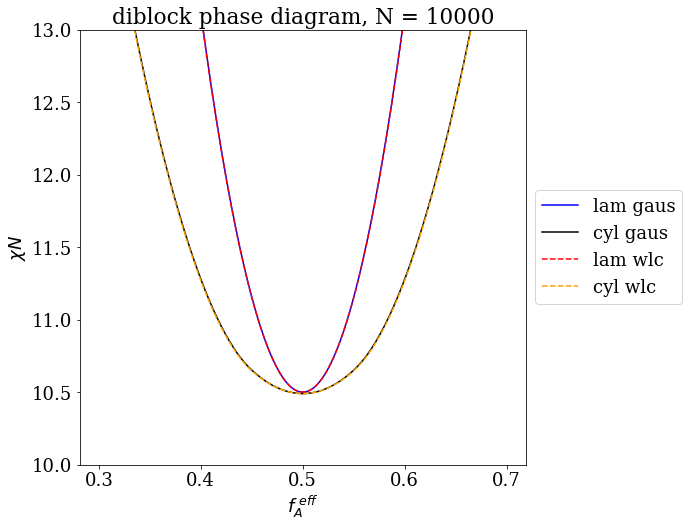

In [43]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)



# ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis", color = "grey")
# ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl", color = "orange")
# ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam", color = "blue")

# ax.scatter(dis_pnts_vert[::2], dis_pnts_vert[1::2], label = "dis", color = "grey")
# ax.scatter(lam_pnts_vert[::2], lam_pnts_vert[1::2], label = "mono lam", color = "purple")
# ax.scatter(cyl_pnts_vert[::2], cyl_pnts_vert[1::2], label = "cyl", color = "yellow")



new_fa = np.arange(0.301, 0.7, 0.001)
new_fa_lam = np.arange(0.4, 0.6, 0.001)

plt.plot(new_fa_lam, laminterp(new_fa_lam), label = "lam gaus", color = "blue")
plt.plot(new_fa, disinterp(new_fa), label = "cyl gaus", color = "black")

plt.plot(new_fa_lam, laminterp_vert(new_fa_lam), label = "lam wlc", linestyle = "--", color = "red")
plt.plot(new_fa, disinterp_vert(new_fa), label = "cyl wlc", linestyle = "--", color = "orange")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(10, 13)
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{\  eff}$")
ax.set_title("diblock phase diagram, N = " + str(N) )

Text(0.5, 1.0, 'diblock phase diagram, N = 10000')

<Figure size 432x288 with 0 Axes>

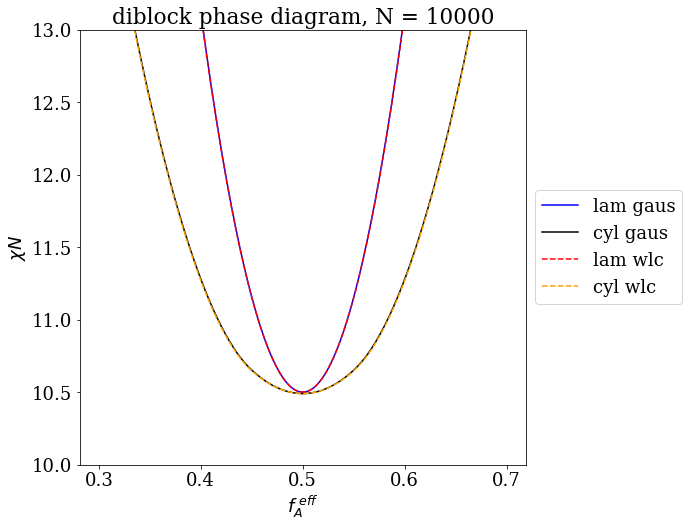

In [30]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)



# ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis", color = "grey")
# ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl", color = "orange")
# ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam", color = "blue")

# ax.scatter(dis_pnts_vert[::2], dis_pnts_vert[1::2], label = "dis", color = "grey")
# ax.scatter(lam_pnts_vert[::2], lam_pnts_vert[1::2], label = "mono lam", color = "purple")
# ax.scatter(cyl_pnts_vert[::2], cyl_pnts_vert[1::2], label = "cyl", color = "yellow")



new_fa = np.arange(0.301, 0.7, 0.001)
new_fa_lam = np.arange(0.4, 0.6, 0.001)

plt.plot(new_fa_lam, laminterp(new_fa_lam), label = "lam gaus", color = "blue")
plt.plot(new_fa, disinterp(new_fa), label = "cyl gaus", color = "black")

plt.plot(new_fa_lam, laminterp_vert(new_fa_lam), label = "lam wlc", linestyle = "--", color = "red")
plt.plot(new_fa, disinterp_vert(new_fa), label = "cyl wlc", linestyle = "--", color = "orange")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(10, 13)
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{\  eff}$")
ax.set_title("diblock phase diagram, N = " + str(N) )

## structure factor comparisons

In [ ]:
#single point tests
N = 1000
FA = 0.7

N_m = 100
b = 1
M = 10
poly_mat = [0,0,0,0,0,0,0,1,1,1]
dens = [1.]


KS = spinodal(pset, N, FA)
q_star = KS[0]

q_star_gaus = find_kstar(poly_mat, dens, N_m, b, M)

q_star_gaus_new = spinodal_gaus(poly_mat, dens, N_m, b, M)

CHI = 10
lam_g2 = (1/2) * 2 * (1) * gamma2_E(poly_mat, dens, N_m, b, M, q_star_gaus_new, CHI)                

lam_g2_wlc = (1/2) * 2 * (1) * gamma2(pset, N, FA, q_star_gaus_new, CHI)                

In [ ]:

# sf2AA, sf2AB, sf2BB = calc_sf2(poly_mat, dens, N_m, b, k_vec = np.logspace(-2, 2, 50))
# sf2AA /= N**2
# sf2AB /= N**2
# sf2BB /= N**2


In [ ]:
sf2AA, sf2AB, sf2BB = calc_sf2(poly_mat, dens, N_m, b, k_vec)

In [ ]:
%%time
#VERTEX

N = 1000
FA = 0.7

N_m = 100
b = 1
M = 10
poly_mat = [0,0,0,0,0,0,0,1,1,1]
dens = [1.]

nk = 50
k_vec = np.logspace(-2, 2, nk)

sf2AA, sf2AB, sf2BB = calc_sf2(poly_mat, dens, N_m, b, k_vec)

s2_arr_vert_AA = np.zeros(nk)
s2_arr_vert_AB = np.zeros(nk)
s2_arr_vert_BB = np.zeros(nk)
for i in range(nk):
    Ks = k_vec[i]
    s2mat = s2wlc(pset, N, FA, Ks, sequence='all')
    Ks = k_vec[i]
    s2_arr_vert_AA[i] = s2mat[0][0]
    s2_arr_vert_AB[i] = s2mat[0][1]
    s2_arr_vert_BB[i] = s2mat[1][1]
    

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, sf2AA, label = "AA")
plt.plot(k_vec, sf2AB, label = "AB")
plt.plot(k_vec, sf2BB, label = "BB")

plt.plot(k_vec, s2_arr_vert_AA, label = "AA vert", linestyle = "--")
plt.plot(k_vec, s2_arr_vert_AB, label = "AB vert", linestyle = "--")
plt.plot(k_vec, s2_arr_vert_BB, label = "BB vert", linestyle = "--")

# plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

# plt.title("S2")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))
k3_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

theta_1 = (2/3)*np.pi#2* np.pi * 1 / 3
theta_2 = 0#2*np.pi/3

frac = 1
k2_vec[:, 0] += frac * np.cos(theta_1) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta_1) * np.logspace(np.log10(k0), np.log10(kf), nk)

k3_vec[:, 0] += frac * np.cos(theta_2) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec[:, 1] += frac * np.sin(theta_2) * np.logspace(np.log10(k0), np.log10(kf), nk)


k4_vec = - (k1_vec + k2_vec + k3_vec)

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))

In [ ]:
N = 1000
FA = 0.7

N_m = 100
b = 1
M = 10
poly_mat = [0,0,0,0,0,0,0,1,1,1]
dens = [1.]

In [ ]:
%%time
#VERTEX

# FA = 0.75
# N = 400.
s3_arr_vert_AAA = np.zeros(nk)
s3_arr_vert_AAB = np.zeros(nk)
s3_arr_vert_ABB = np.zeros(nk)
s3_arr_vert_BBB = np.zeros(nk)

s3_arr_vert_ABA = np.zeros(nk)
s3_arr_vert_BAB = np.zeros(nk)
s3_arr_vert_BBA = np.zeros(nk)
s3_arr_vert_BAA = np.zeros(nk)

for i in range(nk):
#     Ks = k1_vec[i], k1_vec[i], -2*k1_vec[i]
    Ks = k1_vec[i], k2_vec[i], -k1_vec[i] - k2_vec[i]
#     Ks = k1_vec[i], -k1_vec[i], 0
    s3_mat = (s3wlc(pset, N, FA, Ks, sequence='all'))/N**3
    s3_arr_vert_AAA[i] = s3_mat[0][0][0]
    s3_arr_vert_AAB[i] = s3_mat[0][0][1]
    s3_arr_vert_ABA[i] = s3_mat[0][1][0]
    s3_arr_vert_BAA[i] = s3_mat[1][0][0]
    s3_arr_vert_ABB[i] = s3_mat[0][1][1]
    s3_arr_vert_BAB[i] = s3_mat[1][0][1]
    s3_arr_vert_BBA[i] = s3_mat[1][1][0]
    s3_arr_vert_BBB[i] = s3_mat[1][1][1]
# s4_arr_vert_BBBB[0] = s4_mat[1][1][1][1]

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.plot(k_vec[:n], sf3_homo[:n], label = "homo", linestyle = "-")

# plt.plot(k_vec, sf3_stat, label = "wlcstat homo")

color_wlc = "red"
color_gaus = "black"
plt.plot(k_vec[:], s3_arr_vert_AAA[:], label = "AAA wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], sf3_AAA[:], label = "AAA gaus", linestyle = "--", color = color_gaus, alpha = 0.5)




plt.plot(k_vec[:], s3_arr_vert_AAB[:], label = "AAB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], sf3_AAB[:], label = "AAB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s3_arr_vert_ABA[:], label = "ABA wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], sf3_ABA[:], label = "ABA gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s3_arr_vert_BAA[:], label = "BAA wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], sf3_BAA[:], label = "BAA gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s3_arr_vert_ABB[:], label = "ABB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], sf3_ABB[:], label = "ABB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s3_arr_vert_BAB[:], label = "BAB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], sf3_BAB[:], label = "BAB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s3_arr_vert_BBA[:], label = "BBA wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], sf3_BBA[:], label = "BBA gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s3_arr_vert_BBB[:], label = "BBB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], sf3_BBB[:], label = "BBB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.xscale('log')
plt.yscale('log')

plt.title(r"block copolymer, cylindrical k, $\theta_{k_1,k_2} = \frac{2 \pi}{3}$, N = " + str(N) + ", $f_A$ = " + str(FA))
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{3}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.ylim((1e-10, 1e0))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
N = 1000
FA = 0.7

N_m = 100
b = 1
M = 10
poly_mat = [0,0,0,0,0,0,0,1,1,1]
dens = [1.]

In [ ]:
%%time
# s4_AAAA, s4_AAAB, s4_AABB, s4_ABAB, s4_ABBA,\
#             s4_ABBB, s4_BABB, s4_BBAB, s4_BBBA, s4_BBBB = calc_sf4(poly_mat, dens, N_m, b, k1_vec[:], -k1_vec[:], k1_vec[:])

s4_mat = calc_sf4(poly_mat, dens, N_m, b, k1_vec[:], -k1_vec[:], k1_vec[:])

In [ ]:
%%time
#VERTEX

# FA = 0.75
# N = 400.
s4_arr_vert_AAAA = np.zeros(nk)
s4_arr_vert_AAAB = np.zeros(nk)
s4_arr_vert_AABB = np.zeros(nk)
s4_arr_vert_ABAB = np.zeros(nk)
s4_arr_vert_ABBA = np.zeros(nk)
s4_arr_vert_ABBB = np.zeros(nk)
s4_arr_vert_BABB = np.zeros(nk)
s4_arr_vert_BBAB = np.zeros(nk)
s4_arr_vert_BBBA = np.zeros(nk)
s4_arr_vert_BBBB = np.zeros(nk)

for i in range(nk):
    Ks = k1_vec[i], -k1_vec[i], k1_vec[i], -k1_vec[i]
#     Ks = k1_vec[i], -k1_vec[i], k2_vec[i], -k2_vec[i]
    s4_mat = (s4wlc(pset, wigset, N, FA, Ks, sequence='all'))
    s4_arr_vert_AAAA[i] = s4_mat[0][0][0][0]
    s4_arr_vert_AAAB[i] = s4_mat[0][0][0][1]
    s4_arr_vert_AABB[i] = s4_mat[0][0][1][1]
    s4_arr_vert_ABAB[i] = s4_mat[0][1][0][1]
    s4_arr_vert_ABBA[i] = s4_mat[0][1][1][0]
    s4_arr_vert_ABBB[i] = s4_mat[0][1][1][1]
    s4_arr_vert_BABB[i] = s4_mat[1][0][1][1]
    s4_arr_vert_BBAB[i] = s4_mat[1][1][0][1]
    s4_arr_vert_BBBA[i] = s4_mat[1][1][1][0]
    s4_arr_vert_BBBB[i] = s4_mat[1][1][1][1]

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.plot(k_vec[:n], s4_homo[:n], label = "homo", linestyle = "-")

# plt.plot(k_vec, s4_stat, label = "wlcstat homo")

color_wlc = "red"
color_gaus = "black"
plt.plot(k_vec[:], s4_arr_vert_AAAA[:], label = "AAAA wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_AAAA[:], label = "AAAA gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_AAAB[:], label = "AAAB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_AAAB[:], label = "AAAB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_AABB[:], label = "AABB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_AABB[:], label = "AABB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_ABAB[:], label = "ABAB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_ABAB[:], label = "ABAB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_ABBA[:], label = "ABBA wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_ABBA[:], label = "ABBA gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_ABBB[:], label = "ABBB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_ABBB[:], label = "ABBB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_BABB[:], label = "BABB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_BABB[:], label = "BABB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_BBAB[:], label = "BBAB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_BBAB[:], label = "BBAB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_BBBA[:], label = "BBBA wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_BBBA[:], label = "BBBA gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.plot(k_vec[:], s4_arr_vert_BBBB[:], label = "BBBB wlc", linestyle = "-", color = color_wlc)

plt.plot(k_vec[:], s4_BBBB[:], label = "BBBB gaus", linestyle = "--", color = color_gaus, alpha = 0.5)


plt.xscale('log')
plt.yscale('log')

plt.title(r"block copolymer, $k_1, -k_1, k_2, -k_2, \theta_{k_1,k_2} = \frac{2 \pi}{3}$, N = " + str(N) + ", $f_A$ = " + str(FA))
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{4}(K;N)$')
plt.xlim((1e-2, 1e2))
# plt.ylim((1e-10, 1e0))
plt.tight_layout()
plt.legend()
plt.show()

## OLD CODE

In [ ]:
np.sum(np.round(sf3_BBB[:P], 7) == np.round(sf3_BBB_OLD[:P], 7))/P

In [ ]:
# def calc_sf3(poly_mat, dens, N_m, b, k_vec, k_vec_2):
#     # for a gaussian chain of M monomers, each of length N_m
#     # TODO: possible issue with non-cylindrical integrals
#     M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
#     M = np.shape(M3_AAA)[0]
#     nk = len(k_vec)

#     grid = np.indices((M,M,M))
#     j1 = grid[0]
#     j2 = grid[1]
#     j3 = grid[2]
    
#     S3_AAA_arr =  np.zeros(nk)
#     S3_BAA_arr = np.zeros(nk)
#     S3_BBA_arr = np.zeros(nk)
#     S3_BBB_arr = np.zeros(nk)
    
#     S3_ABA_arr = np.zeros(nk)
#     S3_BAB_arr = np.zeros(nk)
    
#     S3_AAB_arr = np.zeros(nk)
#     S3_ABB_arr = np.zeros(nk)

    
#     M3_BAA = M3_AAA[j2, j2, j3] - M3_AAA
#     M3_BBA = M3_AAA + M3_BAA[j1, j3, j3] - M3_AAA[j2,j2,j3]
#     M3_BBB = 1  - M3_AAA[j1, j1, j1] - M3_BAA[j1, j2, j2] - M3_BAA[j1, j3, j3] + M3_AAA[j2,j2,j3] - M3_AAA
    
#     #i think unique
#     M3_ABA = M3_AAA[j1,j1,j3] - M3_AAA
#     M3_BAB = M3_AAA[j2,j2,j2] - M3_AAA[j2,j2,j3] - M3_AAA[j1,j2,j2] + M3_AAA
    
#     #i think degenerate
#     M3_AAB = M3_AAA[j1, j1, j2] - M3_AAA
#     M3_ABB = M3_AAA[j1,j1,j1] - M3_AAA[j1,j1,j2] - M3_AAA[j1,j1,j3] + M3_AAA

#     for i, k_1 in enumerate(k_vec):
#         k_2 = k_vec_2[i]
#         k_12 = k_1 + k_2
        
#         # CASE 1; kA = k1 + k2, kB = k_1; S3 > S2 > S1 and S1 > S2 > S3
#         case1 = [[k_12, k_1], [j3, j2, j1]]
#         # CASE 2; kA = k2, kB = k1 + k2; S2 > S1 > S3 and S3 > S1 > S2
#         case2 = [[k_2, k_12], [j2, j1, j3]]
#         # CASE 3; kA = k2, kB = -k1; S2 > S3 > S1 and S1 > S3 > S2
#         case3 = [[k_2, -k_1], [j2, j3, j1]]
        
#         case_arr = [case1, case2, case3]
# #        for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
# #        then sum over all indices. Need to keep track of js so that aproiate multiplications with cross corr matrix M3        
#         C = np.zeros((M,M,M))

#         for cse in case_arr:
#             kA, kB = cse[0]
#             ordered_js = cse[1]
            
#             xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
#             xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            
#             C = calc_case_deg(C, xm_A, xm_B, ordered_js)
        
#         S3_AAA_arr[i] += np.sum((1/M**3) * M3_AAA * C)*(N**3)
#         S3_BAA_arr[i] += np.sum((1/M**3) * M3_BAA * C)*(N**3)
#         S3_BBA_arr[i] += np.sum((1/M**3) * M3_BBA * C)*(N**3)
#         S3_BBB_arr[i] += np.sum((1/M**3) * M3_BBB * C)*(N**3)
        
#         S3_ABA_arr[i] += np.sum((1/M**3) * M3_ABA * C)*(N**3)
#         S3_BAB_arr[i] += np.sum((1/M**3) * M3_BAB * C)*(N**3)
        
#         S3_AAB_arr[i] += np.sum((1/M**3) * M3_AAB * C)*(N**3)
#         S3_ABB_arr[i] += np.sum((1/M**3) * M3_ABB * C)*(N**3)

#     return S3_AAA_arr, S3_AAB_arr, S3_ABA_arr, S3_BAA_arr, S3_ABB_arr, S3_BAB_arr,  S3_BBA_arr, S3_BBB_arr

# def calc_case_deg(C, xm_A, xm_B, ordered_js):

#     jmax, jmid, jmin = ordered_js
#     ordered_js.reverse()
#     jmax_d, jmid_d, jmin_d = ordered_js
    
#     cylindrical = False
#     epsilon = 0.0000001
#     if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
#         cylindrical = True
    
#     xm_A_eq_0 = False
#     if xm_A < 1e-5:
#         xm_A_eq_0 = True
        
#     xm_B_eq_0 = False
#     if xm_B < 1e-5:
#         xm_B_eq_0 = True
                
#     #for each sub case, looking at the degenerate case where 1 and 2 are switched
#     constant = np.exp(-xm_A*(jmax - jmid)) * np.exp(-xm_B*(jmid - jmin)) 
#     constant_deg = np.exp(-xm_B*(jmax_d - jmid_d)) * np.exp(-xm_A*(jmid_d - jmin_d))

#     # sub case 1; jmax > jmid > jmin, {s1, s2, s3} any 
#     index = (jmax > jmid) * (jmid > jmin)
#     index_deg = (jmax_d > jmid_d) * (jmid_d > jmin_d) #degeneracy
    
#     if cylindrical == True:
#         integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
#         integral_deg = integral
#     elif xm_B_eq_0:
#         integral = (2*(-1+np.cosh(xm_A)))/ (xm_A**2)
#         integral_deg = (2*(-1+np.cosh(xm_A)))/ (xm_A**2)
#     elif xm_A_eq_0:
#         integral = (2*(-1+np.cosh(xm_B)))/ (xm_B**2)
#         integral_deg = (2*(-1+np.cosh(xm_B)))/ (xm_B**2)
#     else:
#         integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
#         * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))
#         integral_deg = (-2 / (xm_B * (xm_B - xm_A) * xm_A)) \
#         * (-np.sinh(xm_B) + np.sinh(xm_B - xm_A) + np.sinh(xm_A))

#     C[np.where((index) != 0)] += constant[np.where(index != 0)] \
#                                     * integral
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral_deg 
    
#     # sub case 2; jmax = jmid > jmin, s3 > s2, {s1} any
#     index = (jmax == jmid) * (jmid > jmin)
#     index_deg = (jmax_d == jmid_d) * (jmid_d > jmin_d) #degeneracy
    
#     if cylindrical == True:
#         integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
#         integral_deg = integral
#     elif xm_B_eq_0:
#         integral = (-1 + xm_A + np.cosh(xm_A) - np.sinh(xm_A))/ (xm_A**2)
#         integral_deg = (np.exp(-xm_A)*(-1 + np.exp(xm_A))*(1+np.exp(xm_A)*(-1 + xm_A))) / (xm_A**3) 
#     elif xm_A_eq_0:
#         integral = (np.exp(-xm_B)*(-1 + np.exp(xm_B))*(1+np.exp(xm_B)*(-1 + xm_B))) / (xm_B**3) 
#         integral_deg = (-1 + xm_B + np.cosh(xm_B) - np.sinh(xm_B))/ (xm_B**2)
#     else:
#         integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
#         * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))
#         integral_deg = ((-1 + np.exp(xm_A))/(xm_B * (xm_B - xm_A)*xm_A**2)) \
#         * (xm_B + (-1 + np.exp(-xm_B))*xm_A - xm_B*np.cosh(xm_A) + xm_B*np.sinh(xm_A))

#     C[np.where((index) != 0)] += constant[np.where(index != 0)] \
#                                     * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral_deg 

#     # BONUS sub case 4; jmax > jmid = jmin, s2 > s1, {s3} any 
#     index = (jmax > jmid) * (jmid == jmin)
#     index_deg = (jmax_d > jmid_d) * (jmid_d == jmin_d)
    
#     if cylindrical == True:
#         integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
#         integral_deg = integral
#     elif xm_B_eq_0:
#         integral = ((-2+xm_A)*(-1+np.cosh(xm_A))+ (xm_A*np.sinh(xm_A)))/ (xm_A**3)
#         integral_deg = (-1+xm_A+np.cosh(xm_A) - np.sinh(xm_A))/ (xm_A**2)
#     elif xm_A_eq_0:
#         integral = (-1+xm_B+np.cosh(xm_B) - np.sinh(xm_B))/ (xm_B**2)
#         integral_deg = ((-2+xm_B)*(-1+np.cosh(xm_B))+ (xm_B*np.sinh(xm_B)))/ (xm_B**3)
#     else:
#         integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
#         * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)
#         integral_deg = (((-1 + np.exp(xm_B))*(np.exp(-xm_B - xm_A)))/(xm_A * (xm_B - xm_A)*xm_B**2)) \
#         * (-np.exp(xm_B)*xm_B + np.exp(xm_B + xm_A) * (xm_B -xm_A) + np.exp(xm_A)*xm_A)

#     C[np.where((index) != 0)] += constant[np.where(index != 0)] \
#                                     * integral
    
#     C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
#                                     * integral_deg 

#     # sub case 3; jmax = jmid = jmin, s3 > s2 > s1
#     index = (jmax == jmid) * (jmid == jmin)
#     index_deg = (jmax == jmid) * (jmid == jmin)

#     if cylindrical == True:
#         integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
#         integral_deg = integral
#     elif xm_B_eq_0:
#         integral = (2-2*np.exp(-xm_A) - 2*xm_A + xm_A**2)/ (2*xm_A**3)
#         integral_deg = integral
#     elif xm_A_eq_0:
#         integral = (2-2*np.exp(-xm_B) - 2*xm_B + xm_B**2)/ (2*xm_B**3)
#         integral_deg = integral
#     else:
#         integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
#         * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )
#         integral_deg = (1 / (xm_B**2 * xm_A - xm_B * xm_A**2))\
#         * ( xm_B + (((-1 + np.exp(-xm_A)) * xm_B)/(xm_A)) - xm_A + ((xm_A - np.exp(-xm_B)*xm_A)/(xm_B)) )

#     C[np.where(index != 0)] += 1\
#                                     * constant[np.where(index != 0)]\
#                                     * integral

# #                                     * 2 # degeneracy
#     C[np.where(index_deg != 0)] += 1\
#                                     * constant_deg[np.where(index_deg != 0)]\
#                                     * integral_deg

#     return C



In [ ]:
def calc_sf3(poly_mat, dens, N_m, b, k_vec, k_vec_2):
    # for a gaussian chain of M monomers, each of length N_m
    
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)
    N = M*N_m

    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr =  np.zeros(nk)
    S3_BAA_arr = np.zeros(nk)
    S3_BBA_arr = np.zeros(nk)
    S3_BBB_arr = np.zeros(nk)
    
    S3_ABA_arr = np.zeros(nk)
    S3_BAB_arr = np.zeros(nk)
    
    S3_AAB_arr = np.zeros(nk)
    S3_ABB_arr = np.zeros(nk)

    
    M3_BAA = M3_AAA[j2, j2, j3] - M3_AAA
    M3_BBA = M3_AAA + M3_BAA[j1, j3, j3] - M3_AAA[j2,j2,j3]
    M3_BBB = 1  - M3_AAA[j1, j1, j1] - M3_BAA[j1, j2, j2] - M3_BAA[j1, j3, j3] + M3_AAA[j2,j2,j3] - M3_AAA
    
    M3_ABA = M3_AAA[j1,j1,j3] - M3_AAA
    M3_BAB = M3_AAA[j2,j2,j2] - M3_AAA[j2,j2,j3] - M3_AAA[j1,j2,j2] + M3_AAA
    M3_AAB = M3_AAA[j1, j1, j2] - M3_AAA
    M3_ABB = M3_AAA[j1,j1,j1] - M3_AAA[j1,j1,j2] - M3_AAA[j1,j1,j3] + M3_AAA
    
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2

        # CASE 1; kA = k1 + k2, kB = k_1; S3 > S2 > S1 and S1 > S2 > S3
        case1 = [[k_12, k_1], [j3, j2, j1]]

        # CASE 2; kA = k2, kB = k1 + k2; S2 > S1 > S3 and S3 > S1 > S2
        case2 = [[k_2, k_12], [j2, j1, j3]]
        
        # CASE 3; kA = k2, kB = -k1; S2 > S3 > S1 and S1 > S3 > S2
        case3 = [[k_2, -k_1], [j2, j3, j1]]
        
        case_arr = [case1, case2, case3]#, case1deg, case2deg, case3deg]
        # need to consider degenerate cases. flipping each element in array, then appending to original case array
        case_arr = np.vstack((case_arr, [[np.flipud(el) for el in cse] for cse in case_arr]))
        
#        for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
#        then sum over all indices. Need to keep track of js so that aproiate multiplications with cross corr matrix M3        
        C = np.zeros((M,M,M))

        for cse in case_arr:
            kA, kB = cse[0]
            ordered_js = cse[1]
            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            
            C = calc_case(C, xm_A, xm_B, ordered_js)
    
        S3_AAA_arr[i] += np.sum((1/M**3) * M3_AAA * C)*(N**3)
        S3_BAA_arr[i] += np.sum((1/M**3) * M3_BAA * C)*(N**3)
        S3_BBA_arr[i] += np.sum((1/M**3) * M3_BBA * C)*(N**3)
        S3_BBB_arr[i] += np.sum((1/M**3) * M3_BBB * C)*(N**3)
        
        S3_ABA_arr[i] += np.sum((1/M**3) * M3_ABA * C)*(N**3)
        S3_BAB_arr[i] += np.sum((1/M**3) * M3_BAB * C)*(N**3)
        
        S3_AAB_arr[i] += np.sum((1/M**3) * M3_AAB * C)*(N**3)
        S3_ABB_arr[i] += np.sum((1/M**3) * M3_ABB * C)*(N**3)

    return S3_AAA_arr, S3_AAB_arr, S3_ABA_arr, S3_BAA_arr, S3_ABB_arr, S3_BAB_arr,  S3_BBA_arr, S3_BBB_arr

def calc_case(C, xm_A, xm_B, ordered_js):

    jmax, jmid, jmin = ordered_js
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    
    xm_A_eq_0 = False
    if xm_A < 1e-5:
        xm_A_eq_0 = True
        
    xm_B_eq_0 = False
    if xm_B < 1e-5:
        xm_B_eq_0 = True

    #for each sub case, looking at the degenerate case where 1 and 2 are switched
    constant = np.exp(-xm_A*(jmax - jmid)) * np.exp(-xm_B*(jmid - jmin)) 

    # sub case 1; jmax > jmid > jmin, {s1, s2, s3} any 
    index = (jmax > jmid) * (jmid > jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    elif xm_B_eq_0:
        integral = (2*(-1+np.cosh(xm_A)))/ (xm_A**2)
    elif xm_A_eq_0:
        integral = (2*(-1+np.cosh(xm_B)))/ (xm_B**2)
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    # sub case 2; jmax = jmid > jmin, s3 > s2, {s1} any
    index = (jmax == jmid) * (jmid > jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    elif xm_B_eq_0:
        integral = (-1 + xm_A + np.cosh(xm_A) - np.sinh(xm_A))/ (xm_A**2)
    elif xm_A_eq_0:
        integral = (np.exp(-xm_B)*(-1 + np.exp(xm_B))*(1+np.exp(xm_B)*(-1 + xm_B))) / (xm_B**3)   
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral 

    # BONUS sub case 4; jmax > jmid = jmin, s2 > s1, {s3} any 
    index = (jmax > jmid) * (jmid == jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    elif xm_B_eq_0:
        integral = ((-2+xm_A)*(-1+np.cosh(xm_A))+ (xm_A*np.sinh(xm_A)))/ (xm_A**3)
    elif xm_A_eq_0:
        integral = (-1+xm_B+np.cosh(xm_B) - np.sinh(xm_B))/ (xm_B**2)
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral 

    # sub case 3; jmax = jmid = jmin, s3 > s2 > s1
    index = (jmax == jmid) * (jmid == jmin)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    elif xm_B_eq_0:
        integral = (2-2*np.exp(-xm_A) - 2*xm_A + xm_A**2)/ (2*xm_A**3)
    elif xm_A_eq_0:
        integral = (2-2*np.exp(-xm_B) - 2*xm_B + xm_B**2)/ (2*xm_B**3)
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral \
    return C


In [ ]:
def calc_sf_old(poly_mat, dens, N_m, b, k_vec, k_vec_2, k_vec_3):
    M4_AAAA = calc_monomer_matrix_4(poly_mat, dens)
    M = np.shape(M4_AAAA)[0]
    nk = len(k_vec)

    grid = np.indices((M,M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    j4 = grid[3]
    
    S4_AAAA_arr = np.zeros(nk)
    S4_AAAB_arr = np.zeros(nk)
    S4_AABB_arr = np.zeros(nk)
    S4_ABBB_arr = np.zeros(nk)
    S4_BBBB_arr = np.zeros(nk)
    
    M4_BAAA = M4_AAAA[j2, j2, j3, j4] - M4_AAAA
    M4_BBAA = M4_BAAA[j1, j3, j3, j4] - M4_BAAA
    M4_BBBA = M4_BBAA[j1, j2, j4, j4] - M4_BBAA
    M4_BBBB = 1 - M4_AAAA[j1, j1, j1, j1] - M4_AAAA[j2, j2, j2, j2] - M4_AAAA[j3, j3, j3, j3]  + M4_AAAA[j1, j1, j3, j3]\
    + M4_AAAA[j2, j2, j3, j3] + M4_AAAA[j1, j1, j2, j2] - M4_AAAA[j1, j2, j3, j3] - M4_BBBA

    for i, k1 in enumerate(k_vec):
        k2 = k_vec_2[i]
        k3 = k_vec_3[i]
        k12 = k1 + k2
        k13 = k1 + k3
        k23 = k2 + k3
        k123 = k1 + k2 + k3
        
        # CASE 1; kA = k1 + k2 + k3; kB = k_1 + k_2; kC = k_1  S4 > S3 > S2 > S1 (and reverse). All cases on wlcstat
        case1 = [[k123, k12, k1], [j4, j3, j2, j1]]
        case2 = [[k123, k12, k2], [j4, j3, j1, j2]]
        case3 = [[k123, k13, k1], [j4, j2, j3, j1]]
        case4 = [[k123, k23, k2], [j4, j1, j3, j2]]
        case5 = [[k123, k13, k3], [j4, j2, j1, j3]]
        case6 = [[k123, k23, k3], [j4, j1, j2, j3]]
        case7 = [[-k3, k12, k1], [j3, j4, j2, j1]]
        case8 = [[-k3, k12, k2], [j3, j4, j1, j2]]
        case9 = [[-k2, k13, k1], [j2, j4, j3, j1]]
        case10 = [[-k1, k23, k2], [j1, j4, j3, j2]]
        case11 = [[-k2, k13, k3], [j2, j4, j1, j3]]
        case12 = [[-k1, k23, k3], [j1, j4, j2, j3]]
        
        case_arr = [case1, case2, case3, case4, case5, case6, \
                   case7, case8, case9, case10, case11, case12]
        
        C = np.zeros((M,M,M,M))
        for cse in case_arr:
            kA, kB, kC = cse[0]
            ordered_js = cse[1]
            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            xm_C = (1/6) * N_m * b**2 * np.linalg.norm(kC)**2
            
            print("xm_A")
            print(xm_A)
            print("xm_B")
            print(xm_B)
            print("xm_C")
            print(xm_C)
            C = calc_case_s4_old(C, xm_A, xm_B, xm_C, ordered_js) 
            
        S4_AAAA_arr[i] += np.sum((1/M**4) * M4_AAAA * C)
        S4_AAAB_arr[i] += np.sum((1/M**4) * M4_BAAA * C)
        S4_AABB_arr[i] += np.sum((1/M**4) * M4_BBAA * C)
        S4_ABBB_arr[i] += np.sum((1/M**4) * M4_BBBA * C)
        S4_BBBB_arr[i] += np.sum((1/M**4) * M4_BBBB * C)
        
    return S4_AAAA_arr, S4_AAAB_arr, S4_AABB_arr, S4_ABBB_arr, S4_BBBB_arr 


def calc_case_s4_old(C, xm_A, xm_B, xm_C, ordered_js):

    jmax, jupp, jlow, jmin = ordered_js
    ordered_js.reverse()
    jmax_d, jupp_d, jlow_d, jmin_d = ordered_js
    
    xmA_eq_xmB = False
    xmA_eq_xmC = False
    xmB_eq_xmC = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        xmA_eq_xmB = True
    if xm_A + epsilon > xm_C and xm_A - epsilon < xm_C:
        xmA_eq_xmC = True
    if xm_B + epsilon > xm_C and xm_B - epsilon < xm_C:
        xmB_eq_xmC = True
#     print("xmA_eq_xmB")
#     print(xmA_eq_xmB)
#     print("xmA_eq_xmC")
#     print(xmA_eq_xmC)
#     print("xmB_eq_xmC")
#     print(xmB_eq_xmC)

    #for each sub case, looking at the degenerate case where 1 and 2 are switched
    constant = np.exp(-xm_A*(jmax - jupp)- xm_B*(jupp - jlow) - xm_C*(jlow - jmin))
    constant_deg = np.exp(-xm_A*(jmax_d - jupp_d)- xm_B*(jupp_d - jlow_d) - xm_C*(jlow_d - jmin_d))

    # sub case 1; jmax > jupp > jlow > jmin, {s1234} any
    index = (jmax > jupp) * (jupp > jlow) * (jlow > jmin)
    index_deg = (jmax_d > jupp_d) * (jupp_d > jlow_d) * (jlow_d > jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = 2*(-1 + np.cosh(xm_A)) / xm_A**2
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = (16*np.sinh(xm_A / 2) * np.sinh((xm_A - xm_B)/2) * np.sinh((xm_B - xm_C)/2) * np.sinh(xm_C/2))\
                    / (xm_A * (xm_A - xm_B) * (xm_B - xm_C) * xm_C)
    elif xmA_eq_xmB:
        integral = -(2 / (xm_A*xm_C*(xm_A - xm_C))) * \
                    (-np.sinh(xm_A) + np.sinh(xm_A - xm_C) + np.sinh(xm_C))
    elif xmB_eq_xmC:
        integral = -(2 / (xm_A*xm_B*(xm_A - xm_B))) * \
                    (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))
    elif xmA_eq_xmC:
        integral = (16 / (xm_A**2 * (xm_A - xm_B)**2) )* \
                    np.sinh(xm_A / 2)**2 *np.sinh((xm_A - xm_B) / 2)**2
#     print("subcase 1")
#     print(constant[np.where(index != 0)] \
#                                     * integral)
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
                                    * integral 
    
    # sub case 2; jmax = jupp > jlow > jmin
    index = (jmax == jupp) * (jupp > jlow) * (jlow > jmin)
    index_deg = (jmax_d == jupp_d) * (jupp_d > jlow_d) * (jlow_d > jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (-1 + np.exp(xm_A)) * (-1 + np.exp(xm_A) - xm_A))\
        / (xm_A**3)
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-1+np.exp(xm_C)) * (-np.exp(xm_B)+np.exp(xm_C))\
                    * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B))\
                    / (xm_A*xm_B*xm_C*(xm_A - xm_B) * (xm_C - xm_B))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_C)) * (-np.exp(xm_A)+np.exp(xm_C)) * (-1+np.exp(xm_A) - xm_A))\
        /(xm_A**2*xm_C*(xm_C - xm_A))
    elif xmB_eq_xmC:
        integral = ((-1+np.exp(xm_B))*(xm_A - xm_A*np.exp(-xm_B) + (-1+np.exp(-xm_A))*xm_B))/(xm_B**2*xm_A*(xm_A - xm_B))
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B))*(-1+np.exp(xm_A))*(np.exp(xm_A) - np.exp(xm_B))\
                    *(-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)) / (xm_B*xm_A**2*(xm_A-xm_B)**2)
#     print("subcase 2")
#     print(constant[np.where(index != 0)] \
#                                     * integral)
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
                                    * integral 

    # sub case 3; jmax > jupp = jlow > jmin
    index = (jmax > jupp) * (jupp == jlow) * (jlow > jmin)
    index_deg = (jmax_d > jupp_d) * (jupp_d == jlow_d) * (jlow_d > jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (-1 + np.cosh(xm_A)) / (xm_A**2)
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((1-np.exp(-xm_A))*(-1+np.exp(xm_C))*( ( (1-np.exp(xm_A-xm_B))/(xm_A-xm_B) ) + ( (-1+np.exp(xm_A-xm_C))/(xm_A-xm_C) ) ))/(xm_A*xm_C*(xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_A)) * (-1+np.exp(xm_C)) * (np.exp(xm_A)+np.exp(xm_C)*(-1-xm_A+xm_C)))\
        /(xm_A*xm_C*(xm_A - xm_C)**2)
    elif xmB_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A)) * (-1+np.exp(xm_B)) * (np.exp(xm_B)+np.exp(xm_A)*(-1+xm_A-xm_B)))\
        /(xm_A*xm_B*(xm_A - xm_B)**2)
    elif xmA_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A))**2 * (np.exp(xm_A)+np.exp(xm_B)*(-1-xm_A+xm_B)))/(xm_A**2 * (xm_A - xm_B)**2)
#     print("subcase 3")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
                                    * integral 

    # sub case 4; jmax > jupp > jlow = jmin
    index = (jmax > jupp) * (jupp > jlow) * (jlow == jmin)
    index_deg = (jmax_d > jupp_d) * (jupp_d > jlow_d) * (jlow_d == jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = ((2+xm_A)*(-1+np.cosh(xm_A)) - xm_A*np.sinh(xm_A))/(xm_A**3)
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-1+np.exp(xm_A)) * (-np.exp(xm_B)+np.exp(xm_A))\
                    * (-np.exp(xm_B)*xm_B + np.exp(xm_C + xm_B)*(xm_B-xm_C) + np.exp(xm_C)*xm_C))\
                    / (xm_A*xm_B*xm_C*(xm_A - xm_B) * (xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A-xm_C)) * (-1+np.exp(xm_A)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A+xm_C)*(xm_A-xm_C)+np.exp(xm_C)*xm_C)) / (xm_A**2*xm_C*(xm_A - xm_C))
    elif xmB_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A)) * (-np.exp(xm_A)+np.exp(xm_B)) * (-1+np.exp(xm_B) - xm_B))\
        /(xm_A*xm_B**2*(xm_B - xm_A))
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B))*(-1+np.exp(xm_A))*(np.exp(xm_A) - np.exp(xm_B))\
                    *(-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)) / (xm_B*xm_A**2*(xm_A-xm_B)**2)

#     print("subcase 4")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
                                    * integral 
    
    # sub case 5; jmax == jupp == jlow > jmin
    index = (jmax == jupp) * (jupp == jlow) * (jlow > jmin)
    index_deg = (jmax_d == jupp_d) * (jupp_d == jlow_d) * (jlow_d > jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (-1 + np.exp(xm_A)) * (-2 + 2*np.exp(xm_A) - 2*xm_A - xm_A**2))\
        / (2*xm_A**4)
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((-1+np.exp(xm_C)) * (  ( (np.exp(-xm_B))/((xm_A-xm_B)*xm_B)   )  +  ( (xm_B - xm_C)/(xm_A*xm_B*xm_C)  )  +   (   (np.exp(-xm_C))/(xm_C*(xm_C-xm_A))    )  +    (    (np.exp(-xm_A)*(-xm_B+xm_C)) / ( xm_A*(xm_A-xm_B)*(xm_A-xm_C))  )   ))/((xm_B-xm_C)*xm_C)
    elif xmA_eq_xmB:
        integral = ((-1+np.exp(xm_C))* (  (-np.exp(-xm_C) * xm_A**2)     +    ((xm_A-xm_C)**2)    +     (np.exp(-xm_A)*xm_C*(xm_A**2 - xm_A*(-2+xm_C)-xm_C)) ))/(xm_A**2*xm_C**2*(xm_A-xm_C)**2)
    elif xmB_eq_xmC:
        integral = -((-1+np.exp(xm_B))* (  (np.exp(-xm_A) * xm_B**2)     +    -((xm_A-xm_B)**2)    +     (np.exp(-xm_B)*xm_A*(xm_A*(1+xm_B) - xm_B*(2+xm_B))) ))/(xm_B**3*xm_A*(xm_A-xm_B)**2)
    elif xmA_eq_xmC:
        integral = ((-1+np.exp(xm_A))* (  (-np.exp(-xm_B) * xm_A**2)     +    ((xm_A-xm_B)**2)    +     (np.exp(-xm_A)*xm_B*(xm_A**2 - xm_A*(-2+xm_B)-xm_B)) ))/(xm_A**3*xm_B*(xm_A-xm_B)**2)

#     print("subcase 5")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
                                    * integral 
    
    # sub case 6; jmax > jupp == jlow = jmin
    index = (jmax > jupp) * (jupp == jlow) * (jlow == jmin)
    index_deg = (jmax_d > jupp_d) * (jupp_d == jlow_d) * (jlow_d == jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = ((-1 + np.exp(-xm_A)) * (2 - 2*np.exp(xm_A) + 2*xm_A + xm_A**2))\
        / (2*xm_A**4)
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ( (np.exp(-xm_A - xm_B - xm_C)) * (-1+np.exp(xm_A)) * \
                   (          (-np.exp(xm_A+xm_B)*xm_A*(xm_A-xm_B)*xm_B)      +         (np.exp(xm_A+xm_C)*xm_A*(xm_A-xm_C)*xm_C)     +       (np.exp(xm_B+xm_C)*(xm_B-xm_C)*(np.exp(xm_A)*(xm_A-xm_B)*(xm_A-xm_C) -xm_B*xm_C) )     ))\
                    / (xm_A**2 * (xm_A - xm_B) * xm_B * (xm_A-xm_C) * (xm_B - xm_C) * xm_C)
    elif xmA_eq_xmB:
        integral = ( (np.exp(-xm_A - xm_C)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_A)*xm_A**2) +   (np.exp(xm_A+xm_C)*(xm_A-xm_C)**2)    +    -(np.exp(xm_C)*xm_C*(-xm_A**2+xm_A*(-2+xm_C)+xm_C)) ))/ (xm_A**3*(xm_A-xm_C)**2*xm_C)
    elif xmB_eq_xmC:
        integral = ( (np.exp(-xm_A - xm_B)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_B)*xm_B**2) +   (np.exp(xm_A+xm_B)*(xm_A-xm_B)**2)    +    -(np.exp(xm_A)*xm_A*(xm_A*(1+xm_B)-xm_B*(2+xm_B))) ))/ (xm_A**2*(xm_A-xm_B)**2*xm_B**2)
    elif xmA_eq_xmC:
        integral = ( (np.exp(-xm_A - xm_B)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_A)*xm_A**2) +   (np.exp(xm_A+xm_B)*(xm_A-xm_B)**2)    +    -(np.exp(xm_B)*xm_B*(-xm_A**2+xm_A*(-2+xm_B)+xm_B)) ))/ (xm_A**3*(xm_A-xm_B)**2*xm_B)
#     print("subcase 6")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
                                    * integral  
    
    # sub case 7; jmax == jupp == jlow = jmin
    index = (jmax == jupp) * (jupp == jlow) * (jlow == jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (6 + 2*(np.exp(xm_A)*(-3+xm_A)) + 4*xm_A + xm_A**2) ) / (2*xm_A**4)
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ( (np.exp(-xm_A)) / (xm_A**2 * (xm_A-xm_B) * (xm_A - xm_C)) )      +      ( (np.exp(-xm_B)) / (xm_B**2 * (xm_B-xm_A) * (xm_B - xm_C)) )     +      ( (np.exp(-xm_C)) / (xm_C**2 * (xm_C-xm_A) * (xm_C - xm_B)) )      +        -(  (xm_B*xm_C + xm_A*(xm_B+xm_C-xm_B*xm_C))   /    (xm_A**2*xm_B**2*xm_C**2)  )
    elif xmA_eq_xmB:
        integral = (  (-xm_A**3) + (np.exp(-xm_C)*xm_A**3) + (xm_A*(xm_A-xm_C)**2*xm_C) + ((3*xm_A-2*xm_C)*xm_C**2) + ( np.exp(-xm_A)*xm_C**2 *(2*xm_C + xm_A*(-3-xm_A+xm_C))) ) / (xm_A**3 * xm_C**2 * (xm_A - xm_C)**2)
    elif xmB_eq_xmC:
        integral = ( ((xm_A - xm_B)**2 * (xm_A*(-2 + xm_B) - xm_B))     +     (np.exp(-xm_A) * xm_B**3)     +    (np.exp(-xm_B)*xm_A**2 * (xm_A*(2+xm_B) - xm_B*(3 + xm_B))  )      ) / (xm_A**2 * (xm_A - xm_B)**2 * xm_B**3)
    elif xmA_eq_xmC:
        integral =  (  (-xm_A**3) + (np.exp(-xm_B)*xm_A**3) + (xm_A*(xm_A-xm_B)**2*xm_B) + ((3*xm_A-2*xm_B)*xm_B**2) + ( np.exp(-xm_A)*xm_B**2 *(2*xm_B + xm_A*(-3-xm_A+xm_B))) ) / (xm_A**3 * xm_B**2 * (xm_A - xm_B)**2)
#     print("subcase 7")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral * 2
    # sub case 8; jmax == jupp > jlow = jmin
    index = (jmax == jupp) * (jupp > jlow) * (jlow == jmin)
    index_deg = (jmax_d == jupp_d) * (jupp_d > jlow_d) * (jlow_d == jmin_d)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (1 + -np.exp(xm_A) +xm_A)**2)\
        / (xm_A**4)
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B) *(-np.exp(xm_B)*xm_B + np.exp(xm_B + xm_C)*(xm_B-xm_C) + np.exp(xm_C)*xm_C) )\
                    / (xm_A*xm_B**2*xm_C*(xm_A - xm_B) * (xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ( (np.exp(-xm_A - xm_C)) * (-1 + np.exp(xm_A)-xm_A) * ( (-np.exp(xm_A)*xm_A) +   (np.exp(xm_A+xm_C)*(xm_A-xm_C))    +  (np.exp(xm_C)*xm_C) ))/ (xm_A**3*(xm_A-xm_C)*xm_C)
    elif xmB_eq_xmC:
        integral = ( (-1+np.exp(xm_B) - xm_B) * (xm_A-np.exp(-xm_B)*xm_A + (-1+np.exp(-xm_A))*xm_B) )/ (xm_A*(xm_A-xm_B)*xm_B**3)
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A+xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)**2) / (xm_A**2*xm_B**2*(xm_A-xm_B)**2)
#     print("subcase 8")
#     print(constant[np.where(index != 0)] \
#                                     * integral)    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    C[np.where((index_deg) != 0)] += constant_deg[np.where(index_deg != 0)] \
                                    * integral     
    return C